In [593]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBRegressor, XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
import scipy
import re
from shapely.geometry import LineString
from scipy.stats.mstats import winsorize

import missingno as msno
import random
import datetime
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# **Objectives**

# **1. Data Understanding & Preparation**

## **A. Data Description**

In [2]:
overview = pd.read_csv('model_development_set.csv', sep=';')
overview.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,label
5409,dd2e783f6686ebbe2c6872a310044dd3,f18f45534e927691de0a021ef58c576f,93700,campo bom,RS,93700,-29.681701,-51.040489,campo bom,RS,45f7d9a94705872dad55bc0c688f9cfd,delivered,2018-03-26 14:02:36,2018-03-26 14:15:17,2018-04-03 21:35:53,2018-04-11 23:12:18,2018-05-03 00:00:00,2,167b4b8c4bd0c401bea62f5e050d70a4,25c5c91f63607446a97b143d2d535d31,2018-04-10 14:15:17,110.00,36.10,1,credit_card,4,292.20,informatica_acessorios,55.0,209.0,1.0,517,39,11,13,35680,itauna,MG,computers_accessories,1
5281,319b159b331531b985da20be3b4cb47e,e30c407b2c1e3e730634996b3c0da9f5,82630,curitiba,PR,82630,-25.383496,-49.207633,curitiba,PR,a2b641f30be1e5a530738ffe99633544,delivered,2017-05-19 18:35:57,2017-05-23 03:25:29,2017-05-23 10:19:33,2017-05-31 09:44:04,2017-06-12 00:00:00,1,f264c1d9b20b5e4a340254d0405e613b,7a67c85e85bb2ce8582c35f2203ad736,2017-05-29 03:25:29,69.99,16.74,1,boleto,1,86.73,cool_stuff,48.0,874.0,1.0,1050,42,25,15,3426,sao paulo,SP,cool_stuff,0
4555,99a377f3bfbb3b62c50282a74ef60580,657672c97a01b0aa5d8d417e75a57f17,23520,rio de janeiro,RJ,23520,-22.940057,-43.674386,rio de janeiro,RJ,c0c876d98ac48f4ddb75a5645f6f5016,delivered,2018-02-06 15:14:10,2018-02-06 16:11:41,2018-02-14 18:27:05,2018-03-05 22:43:31,2018-03-02 00:00:00,1,5bd6493a2d5a384987386f2696bae33d,92eb0f42c21942b6552362b9b114707d,2018-02-12 16:11:41,18.98,14.10,1,credit_card,1,33.08,telefonia,59.0,405.0,1.0,150,19,4,11,3504,sao paulo,SP,telephony,0


In [568]:
overview.shape

(6814, 40)

**Label :**

**CUSTOMER**
* customer_id : Each order has a unique customer_id.
* customer_unique_id : Identifier for customer account
* customer_zip_code_prefix: first five digits of customer zip code
* customer_city : customer city name
* customer_state : customer state

**GEOLOCATION**
* geolocation_zip_code_prefix : first five digits of customer zip code
* geolocation_latitude : latitude
* geolocation_longitude : longitude
* geolocation_city : city name
* geolocation_state : state

**SELLERS**
* seller_id : seller unique identifier
* seller_zip_code_prefix : first 5 digits of seller zip code
* seller_city : seller city name
* seller_state : seller state

**ORDER**
* order_id : product unique identifier
* order_item_id : number of items in the same order
* product_id : product unique identifier
* shipping_limit_date : Shows the seller shipping limit date for sending the order
* price : item price
* freight value : item freight value
* order_status : Reference to the order status (delivered, shipped, etc)
* order_purchase_timestamp : Shows the purchase timestamp
* order_approved_at : Shows the payment approval timestamp
* order_delivered_carrier_date : When order sent to delivery partner
* order_delivered_customer_date : When order received by customer
* order_estimated_delivery_date : Estimated delivery date

**PAYMENTS**
* payment_sequential : a customer may pay an order with more than one payment method.
* payment_type : method of payment chosen by the customer
* payment_installment : number of installments chosen by the customer
* payment_value : price + freight value
  
**PRODUCTS**
* product_id : unique product identifier
* product_category_name : root category of product, in Portuguese
* product_name_length: umber of characters extracted from the product name
* product_description_length (int): number of characters extracted from the product description
* product_photos_qty : number of product published photos
* product_weight_g : product weight measured in grams
* product_length_cm : product length measured in centimeters
* product_height_cm : product height measured in centimeters
* product_width_cm : product width measured in centimeters
* product_category_name : category name in Portuguese
* product_category_name_english : category name in English 

**ORDER_REVIEWS (TARGET)**<br>
label : Whether an order receives five star review (1) or not (0)


## **B. Missing Value Handling & Data Cleaning**

In [3]:
review = pd.read_csv('model_development_set.csv', sep=';')
review = review.drop_duplicates()
review = review.drop(['customer_id', 'customer_unique_id', 'order_id', 'product_id', 'seller_id', 'order_status'], axis=1)
         
review = review.dropna(subset=['order_approved_at']) #Due to it having missing value proportion of ~0.03%
review.head()

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,label
0,36570,vicosa,MG,36570,-20.751405,-42.824725,vicosa,MG,2017-10-27 16:21:02,2017-10-27 17:31:13,2017-11-01 00:07:57,2017-11-06 20:17:37,2017-11-22 00:00:00,1,2017-11-03 16:35:40,1437.0,42.51,1,credit_card,8,1479.51,pcs,55.0,3611.0,4.0,2750,16,31,39,42738,lauro de freitas,BA,computers,0
1,72225,brasilia,DF,72225,-15.817357,-48.113121,brasilia,DF,2017-12-11 13:32:50,2017-12-11 13:50:16,2017-12-11 23:10:08,2017-12-26 19:52:23,2018-01-11 00:00:00,1,2017-12-20 13:50:16,349.9,22.85,1,credit_card,7,372.75,beleza_saude,51.0,625.0,1.0,900,25,12,38,80310,curitiba,PR,health_beauty,0
2,13160,artur nogueira,SP,13160,-22.577270,-47.170631,artur nogueira,SP,2018-02-16 20:24:06,2018-02-16 20:46:34,2018-02-20 15:37:54,2018-03-08 16:12:09,2018-03-15 00:00:00,1,2018-02-22 19:46:34,69.9,12.62,1,credit_card,3,82.52,informatica_acessorios,51.0,518.0,1.0,214,18,14,13,87047,maringa,PR,computers_accessories,0
3,15600,fernandopolis,SP,15600,-20.277672,-50.233246,fernandopolis,SP,2018-01-07 10:16:22,2018-01-08 10:11:22,2018-01-09 20:45:04,2018-01-13 01:03:35,2018-02-05 00:00:00,1,2018-01-17 10:11:22,250.0,35.02,1,credit_card,6,285.02,moveis_decoracao,51.0,756.0,1.0,12250,45,35,45,3204,sao paulo,SP,furniture_decor,0
4,29360,castelo,ES,29360,-20.607682,-41.202173,castelo,ES,2017-07-24 22:09:04,2017-07-24 22:23:14,2017-07-26 11:07:51,2017-08-09 17:17:38,2017-08-28 00:00:00,1,2017-07-30 22:23:14,75.9,25.81,1,credit_card,3,101.71,informatica_acessorios,45.0,267.0,1.0,167,16,12,13,87083,maringa,PR,computers_accessories,1


In [4]:
#Showing columns with missing value (% rows)
review.iloc[:,20:].isna().sum()/len(review)*100

payment_value                    0.000000
product_category_name            1.395007
product_name_lenght              1.395007
product_description_lenght       1.395007
product_photos_qty               1.395007
product_weight_g                 0.000000
product_length_cm                0.000000
product_height_cm                0.000000
product_width_cm                 0.000000
seller_zip_code_prefix           0.000000
seller_city                      0.000000
seller_state                     0.000000
product_category_name_english    1.409692
label                            0.000000
dtype: float64

<AxesSubplot:>

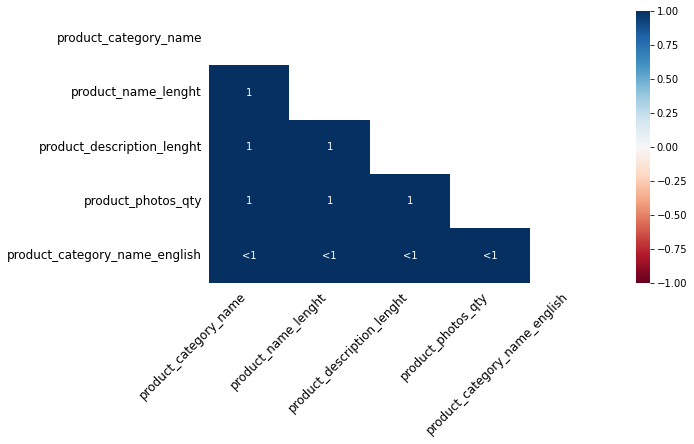

In [5]:
# Missing value correlation
msno.heatmap(review, figsize=(9,5), fontsize=12)

**Due to all heatmap values are 1 or close to 1 (<1)**, we know that missing value from one of these column is highly correlated with the presence of missing value from another column. And since the **proportion of missing value is pretty small (<2%)**, we can **drop them without significant ramification.**

<AxesSubplot:>

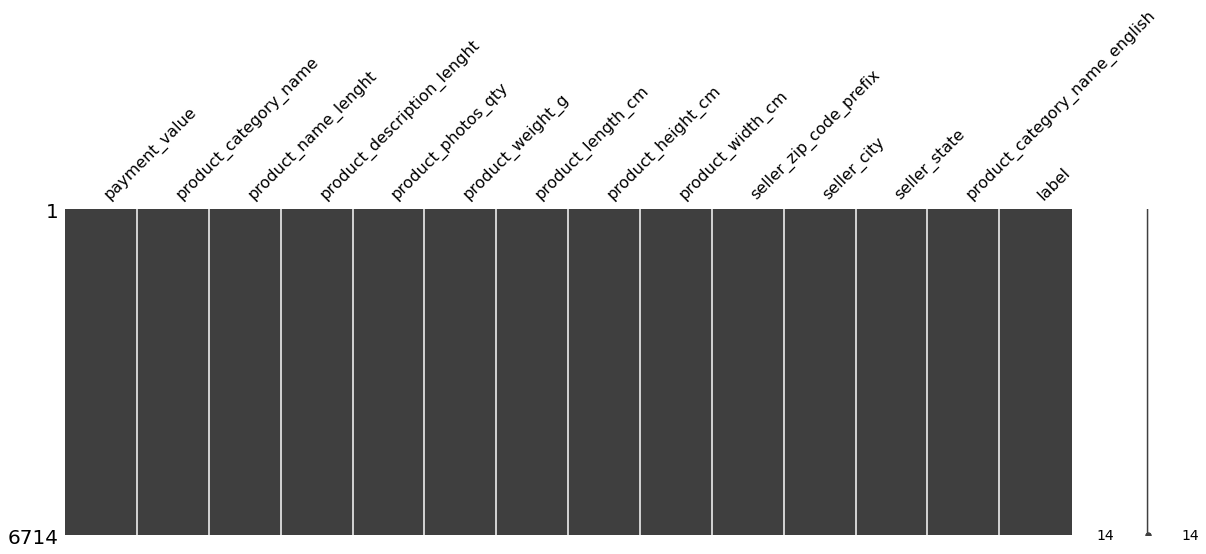

In [6]:
review = review.dropna()
msno.matrix(review.iloc[:,20:], figsize=(20,6))

In [7]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6714 entries, 0 to 6813
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_zip_code_prefix       6714 non-null   int64  
 1   customer_city                  6714 non-null   object 
 2   customer_state                 6714 non-null   object 
 3   geolocation_zip_code_prefix    6714 non-null   int64  
 4   geolocation_lat                6714 non-null   float64
 5   geolocation_lng                6714 non-null   float64
 6   geolocation_city               6714 non-null   object 
 7   geolocation_state              6714 non-null   object 
 8   order_purchase_timestamp       6714 non-null   object 
 9   order_approved_at              6714 non-null   object 
 10  order_delivered_carrier_date   6714 non-null   object 
 11  order_delivered_customer_date  6714 non-null   object 
 12  order_estimated_delivery_date  6714 non-null   o

## **C. Datetime Processing**

In [8]:
# Datetime columns
datetime_col = ['order_purchase_timestamp', 
                'order_approved_at', 
                'order_delivered_carrier_date', 
                'order_delivered_customer_date', 
                'order_estimated_delivery_date', 
                'shipping_limit_date']

#Timedelta result in minutes
def delta_to_minute(delta):
    delta = delta.total_seconds()//60
    return delta
#Timedelta result in hours
def delta_to_hour(delta):
    delta = delta.total_seconds()/3600
    return delta

In [9]:
#Converting values to datetime type
review_datetime = review[datetime_col]
review_datetime = pd.to_datetime(review_datetime.stack(), errors='coerce').unstack()
review_datetime.head(3)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
0,2017-10-27 16:21:02,2017-10-27 17:31:13,2017-11-01 00:07:57,2017-11-06 20:17:37,2017-11-22,2017-11-03 16:35:40
1,2017-12-11 13:32:50,2017-12-11 13:50:16,2017-12-11 23:10:08,2017-12-26 19:52:23,2018-01-11,2017-12-20 13:50:16
2,2018-02-16 20:24:06,2018-02-16 20:46:34,2018-02-20 15:37:54,2018-03-08 16:12:09,2018-03-15,2018-02-22 19:46:34


### **Engineering Datetime Features**

Since all datetime features are in the form of timestamp, new features are created to help gain better features for model or for BI purposes, this includes :
* **Unpacking** purchase timestamp for its year, month, week of the year, and day of the week.
* **Classifying** whether an order is shipped over time limit and whether it's delivered over est. time.
* **Timespan** between order being approved and sent to carrier, the same for time delivered to customer

In [10]:
datetime_eng = pd.DataFrame()
#A. Datetime Unpacking
datetime_eng['order_purchase_year'] = review_datetime['order_purchase_timestamp'].dt.year
datetime_eng['order_purchase_month'] = review_datetime['order_purchase_timestamp'].dt.month
datetime_eng['order_purchase_week'] = review_datetime['order_purchase_timestamp'].dt.isocalendar().week
datetime_eng['order_purchase_dayofweek'] = review_datetime['order_purchase_timestamp'].dt.dayofweek

#B. Overtime
datetime_eng['overtime_shipping'] = (review_datetime['order_delivered_carrier_date'] > review_datetime['shipping_limit_date']).astype('int')
datetime_eng['overtime_delivered'] = (review_datetime['order_delivered_customer_date'] > review_datetime['order_estimated_delivery_date']).astype('int')

#Timedelta features
#Interval between order being approved and delivered by seller
datetime_eng['seller_response_time'] = (review_datetime['order_delivered_carrier_date'] - review_datetime['order_approved_at']).apply(delta_to_hour)
#Interval between order being approved and delivered to customer
datetime_eng['approved_to_delivered'] = (review_datetime['order_delivered_customer_date'] - review_datetime['order_approved_at']).apply(delta_to_hour)
datetime_eng.head()


,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,2017,10,43,4,0,0,102.612222,242.773333
1,2017,12,50,0,0,0,9.331111,366.035278
2,2018,2,7,4,0,0,90.855556,475.426389
3,2018,1,1,6,0,0,34.561667,110.870278
4,2017,7,30,0,0,0,36.743611,378.906667


In [11]:
review_cleaned = review.drop(datetime_col, axis=1)
review_cleaned = pd.concat([review_cleaned, datetime_eng], axis=1)
review_cleaned.head()

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,label,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,36570,vicosa,MG,36570,-20.751405,-42.824725,vicosa,MG,1,1437.0,42.51,1,credit_card,8,1479.51,pcs,55.0,3611.0,4.0,2750,16,31,39,42738,lauro de freitas,BA,computers,0,2017,10,43,4,0,0,102.612222,242.773333
1,72225,brasilia,DF,72225,-15.817357,-48.113121,brasilia,DF,1,349.9,22.85,1,credit_card,7,372.75,beleza_saude,51.0,625.0,1.0,900,25,12,38,80310,curitiba,PR,health_beauty,0,2017,12,50,0,0,0,9.331111,366.035278
2,13160,artur nogueira,SP,13160,-22.577270,-47.170631,artur nogueira,SP,1,69.9,12.62,1,credit_card,3,82.52,informatica_acessorios,51.0,518.0,1.0,214,18,14,13,87047,maringa,PR,computers_accessories,0,2018,2,7,4,0,0,90.855556,475.426389
3,15600,fernandopolis,SP,15600,-20.277672,-50.233246,fernandopolis,SP,1,250.0,35.02,1,credit_card,6,285.02,moveis_decoracao,51.0,756.0,1.0,12250,45,35,45,3204,sao paulo,SP,furniture_decor,0,2018,1,1,6,0,0,34.561667,110.870278
4,29360,castelo,ES,29360,-20.607682,-41.202173,castelo,ES,1,75.9,25.81,1,credit_card,3,101.71,informatica_acessorios,45.0,267.0,1.0,167,16,12,13,87083,maringa,PR,computers_accessories,1,2017,7,30,0,0,0,36.743611,378.906667


## **D. EDA**

I divide this section into 2 parts : **BI EDA and Modelling EDA.**

**BI EDA** is used for providing **BI-related info** regarding this e-commerce company, while **Modelling EDA** (No. 1-3) is used to help the process of **data preprocessing and feature engineering** to build this classifier model.

In [12]:
def unique_values(df):
    for feature in df.columns:
        print('Number of unique values for {} : {}'.format(feature, len(df[feature].unique())))

### **1. Datetime Features EDA**

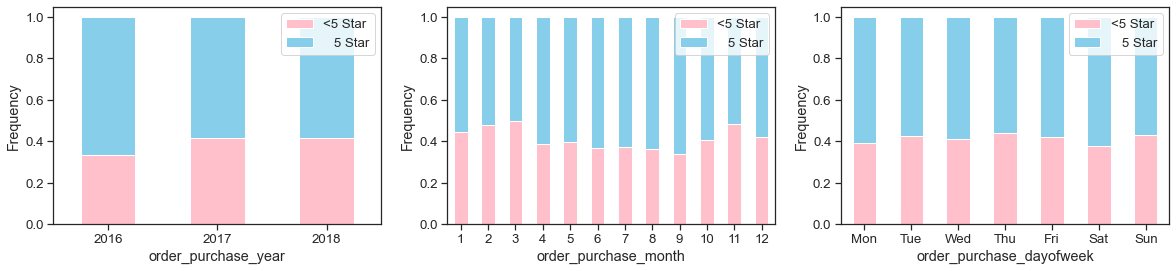

In [13]:
#5-star review frequency on order purchase year, month, and day of the week
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
fig, axs = plt.subplots(ncols=3, sharey = False, figsize = (20,4))

for i, col in enumerate(['order_purchase_year', 'order_purchase_month', 'order_purchase_dayofweek']):
    plt.subplot(1, 3, i+1)
    pd.crosstab(review_cleaned[col], review_cleaned['label'], normalize='index')\
      .plot(kind='bar', stacked=True, color=['pink', 'skyblue'], ax=axs[i])
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.legend(['<5 Star', '   5 Star'])
    
    if col == 'order_purchase_dayofweek':
      plt.xticks(np.arange(0,7,1), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
    else:
      plt.xticks(rotation=0)

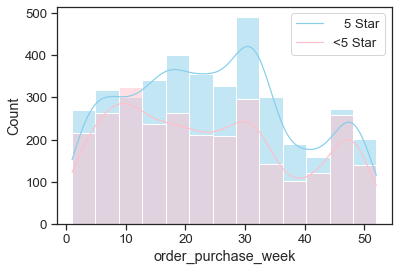

In [14]:
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 
                                                'lines.linewidth': 1.2, 
                                                'lines.markersize': 3.0,})
sns.histplot(review_cleaned, x='order_purchase_week', hue='label', bins=13, kde=True, palette= ['pink', 'skyblue'])
plt.legend(['   5 Star', '<5 Star'])

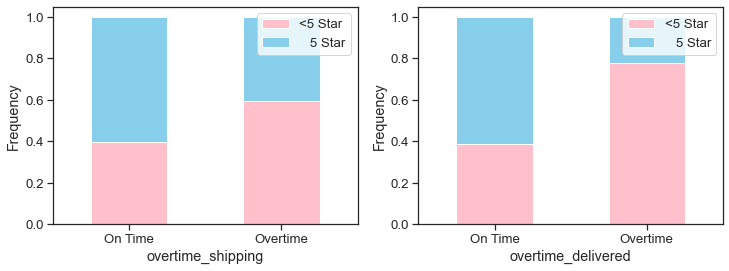

In [15]:
#5-star review frequency on overtime delivery
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
fig, axs = plt.subplots(ncols=2, sharey = False, figsize = (12,4))

for i, col in enumerate(['overtime_shipping', 'overtime_delivered']):
    plt.subplot(1, 2, i+1)
    
    pd.crosstab(review_cleaned[col], review_cleaned['label'], normalize='index')\
      .plot(kind='bar', stacked=True, color=['pink', 'skyblue'], ax=axs[i])
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.legend(['<5 Star', '   5 Star'])
    plt.xticks([1,0], ['Overtime', 'On Time'], rotation=0)

**SUMMARY :**
**Order purchase month and overtime category** potentially have better quality as features than the rest.

### **2. Numerical Features EDA**

In [16]:
review_cleaned_num = review_cleaned.select_dtypes('number')
review_cleaned_num.head()

,customer_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,label,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,36570,36570,-20.751405,-42.824725,1,1437.0,42.51,1,8,1479.51,55.0,3611.0,4.0,2750,16,31,39,42738,0,2017,10,43,4,0,0,102.612222,242.773333
1,72225,72225,-15.817357,-48.113121,1,349.9,22.85,1,7,372.75,51.0,625.0,1.0,900,25,12,38,80310,0,2017,12,50,0,0,0,9.331111,366.035278
2,13160,13160,-22.577270,-47.170631,1,69.9,12.62,1,3,82.52,51.0,518.0,1.0,214,18,14,13,87047,0,2018,2,7,4,0,0,90.855556,475.426389
3,15600,15600,-20.277672,-50.233246,1,250.0,35.02,1,6,285.02,51.0,756.0,1.0,12250,45,35,45,3204,0,2018,1,1,6,0,0,34.561667,110.870278
4,29360,29360,-20.607682,-41.202173,1,75.9,25.81,1,3,101.71,45.0,267.0,1.0,167,16,12,13,87083,1,2017,7,30,0,0,0,36.743611,378.906667


In [17]:
same = (review_cleaned_num['customer_zip_code_prefix'] == review_cleaned_num['geolocation_zip_code_prefix']).astype('int')
same.unique() #We know that we can drop either customer_zip_code_prefix or geolocation_zip_code_prefix

array([1])

In [18]:
#Unique values for each numerical columns
unique_values(review_cleaned_num)

Number of unique values for customer_zip_code_prefix : 2762
Number of unique values for geolocation_zip_code_prefix : 2762
Number of unique values for geolocation_lat : 6516
Number of unique values for geolocation_lng : 6516
Number of unique values for order_item_id : 11
Number of unique values for price : 1511
Number of unique values for freight_value : 2117
Number of unique values for payment_sequential : 14
Number of unique values for payment_installments : 18
Number of unique values for payment_value : 4890
Number of unique values for product_name_lenght : 53
Number of unique values for product_description_lenght : 1663
Number of unique values for product_photos_qty : 17
Number of unique values for product_weight_g : 859
Number of unique values for product_length_cm : 91
Number of unique values for product_height_cm : 87
Number of unique values for product_width_cm : 75
Number of unique values for seller_zip_code_prefix : 1133
Number of unique values for label : 2
Number of unique 

In [19]:
ordinal_cols = ['customer_zip_code_prefix', 'geolocation_zip_code_prefix', 'order_item_id', 'product_photos_qty',
                'payment_sequential', 'payment_installments', 'seller_zip_code_prefix']
ordinal_cols.extend(list(datetime_eng.columns[:-2]))
print(ordinal_cols)

['customer_zip_code_prefix', 'geolocation_zip_code_prefix', 'order_item_id', 'product_photos_qty', 'payment_sequential', 'payment_installments', 'seller_zip_code_prefix', 'order_purchase_year', 'order_purchase_month', 'order_purchase_week', 'order_purchase_dayofweek', 'overtime_shipping', 'overtime_delivered']


In [20]:
review_num_final = review_cleaned_num.drop(ordinal_cols, axis=1)
review_num_final.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,label,seller_response_time,approved_to_delivered
0,-20.751405,-42.824725,1437.0,42.51,1479.51,55.0,3611.0,2750,16,31,39,0,102.612222,242.773333
1,-15.817357,-48.113121,349.9,22.85,372.75,51.0,625.0,900,25,12,38,0,9.331111,366.035278
2,-22.577270,-47.170631,69.9,12.62,82.52,51.0,518.0,214,18,14,13,0,90.855556,475.426389


1. GEOLOCATION LAT


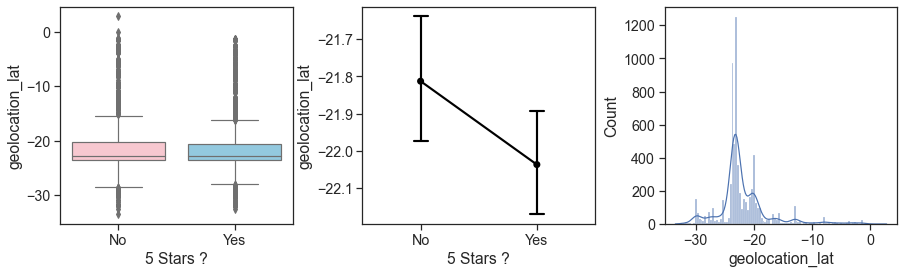

Mean(SD) for 'Yes' in 5 Star Rating? : -22.04(4.24)
Mean(SD) for 'No' in 5 Star Rating? : -21.81(4.61)
----------------------------------------------------------------------------------------------------
2. GEOLOCATION LNG


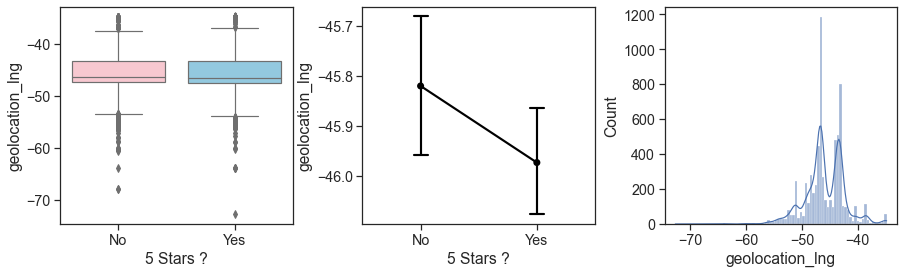

Mean(SD) for 'Yes' in 5 Star Rating? : -45.97(3.49)
Mean(SD) for 'No' in 5 Star Rating? : -45.82(3.62)
----------------------------------------------------------------------------------------------------
3. PRICE


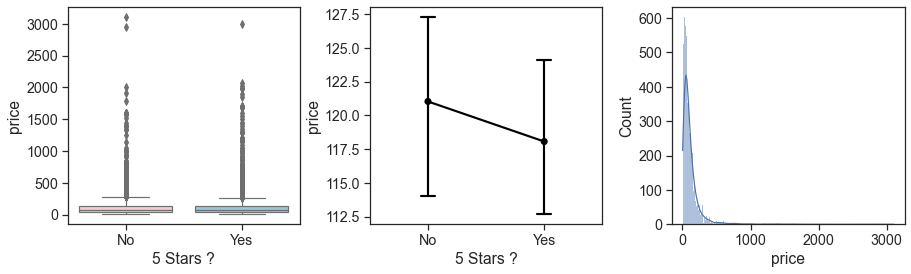

Mean(SD) for 'Yes' in 5 Star Rating? : 118.06(173.98)
Mean(SD) for 'No' in 5 Star Rating? : 121.03(179.76)
----------------------------------------------------------------------------------------------------
4. FREIGHT VALUE


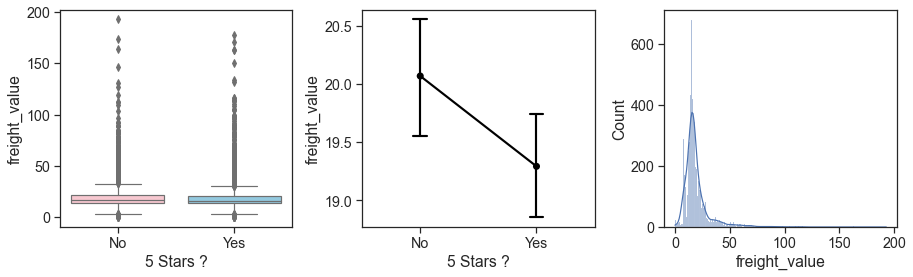

Mean(SD) for 'Yes' in 5 Star Rating? : 19.29(13.71)
Mean(SD) for 'No' in 5 Star Rating? : 20.07(13.83)
----------------------------------------------------------------------------------------------------
5. PAYMENT VALUE


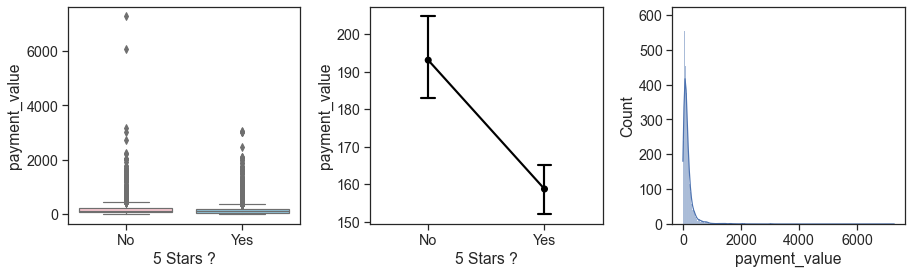

Mean(SD) for 'Yes' in 5 Star Rating? : 158.70(214.14)
Mean(SD) for 'No' in 5 Star Rating? : 193.06(303.32)
----------------------------------------------------------------------------------------------------
6. PRODUCT NAME LENGHT


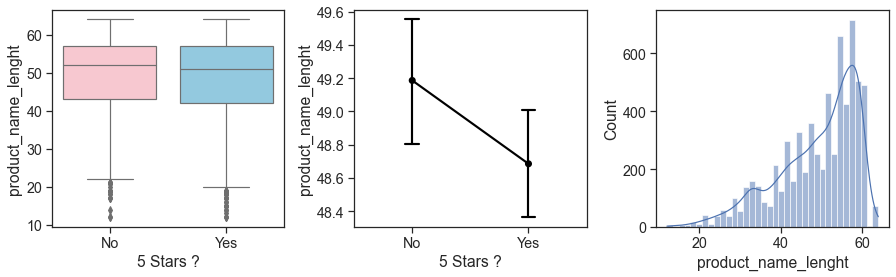

Mean(SD) for 'Yes' in 5 Star Rating? : 48.69(9.97)
Mean(SD) for 'No' in 5 Star Rating? : 49.19(9.74)
----------------------------------------------------------------------------------------------------
7. PRODUCT DESCRIPTION LENGHT


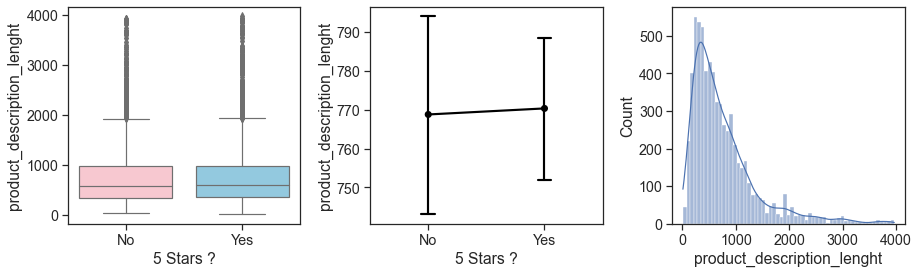

Mean(SD) for 'Yes' in 5 Star Rating? : 770.36(633.24)
Mean(SD) for 'No' in 5 Star Rating? : 768.80(648.48)
----------------------------------------------------------------------------------------------------
8. PRODUCT WEIGHT G


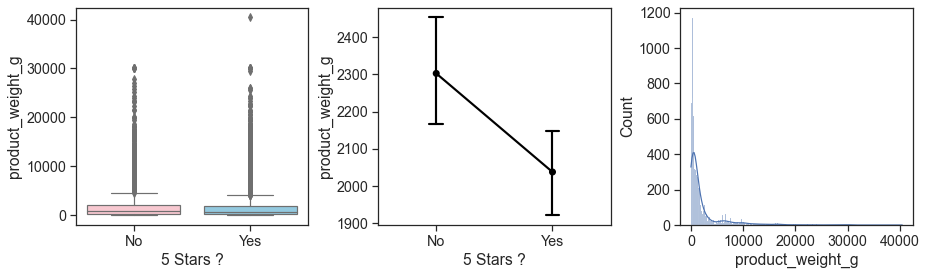

Mean(SD) for 'Yes' in 5 Star Rating? : 2037.69(3624.57)
Mean(SD) for 'No' in 5 Star Rating? : 2302.75(3916.47)
----------------------------------------------------------------------------------------------------
9. PRODUCT LENGTH CM


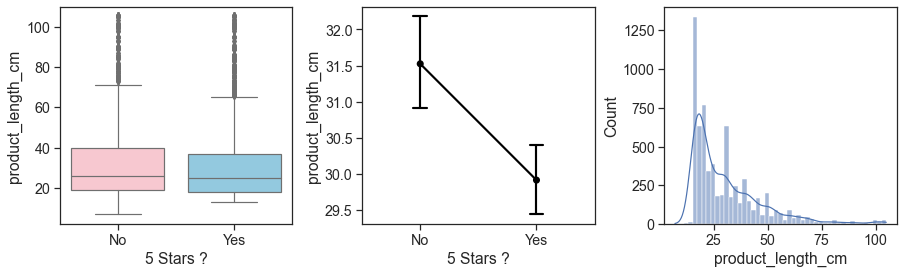

Mean(SD) for 'Yes' in 5 Star Rating? : 29.92(15.84)
Mean(SD) for 'No' in 5 Star Rating? : 31.53(17.34)
----------------------------------------------------------------------------------------------------
10. PRODUCT HEIGHT CM


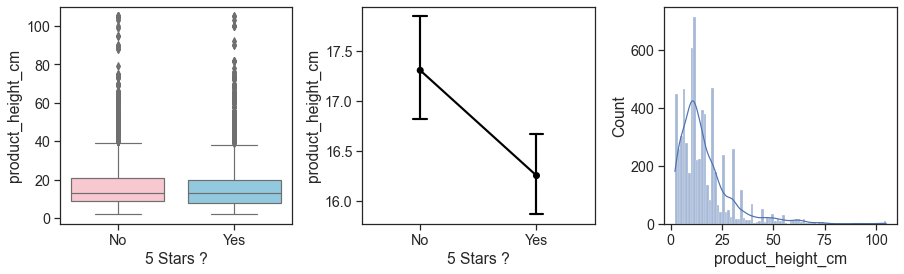

Mean(SD) for 'Yes' in 5 Star Rating? : 16.25(12.99)
Mean(SD) for 'No' in 5 Star Rating? : 17.31(14.52)
----------------------------------------------------------------------------------------------------
11. PRODUCT WIDTH CM


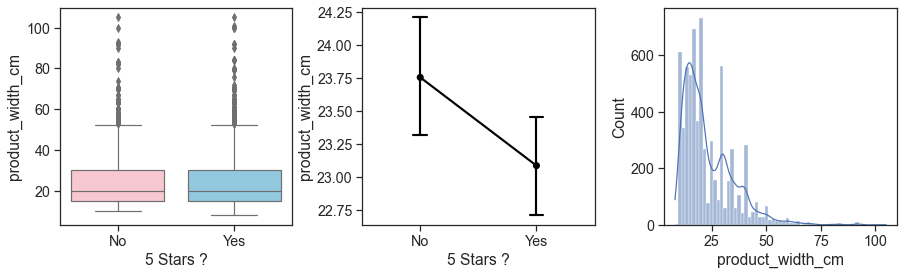

Mean(SD) for 'Yes' in 5 Star Rating? : 23.09(11.77)
Mean(SD) for 'No' in 5 Star Rating? : 23.76(12.20)
----------------------------------------------------------------------------------------------------
12. LABEL
12. SELLER RESPONSE TIME


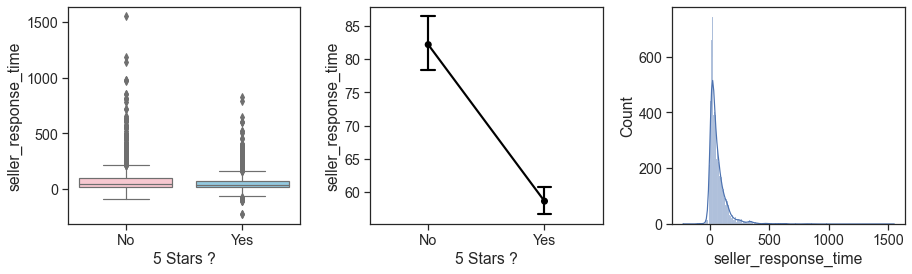

Mean(SD) for 'Yes' in 5 Star Rating? : 58.67(64.45)
Mean(SD) for 'No' in 5 Star Rating? : 82.19(109.23)
----------------------------------------------------------------------------------------------------
13. APPROVED TO DELIVERED


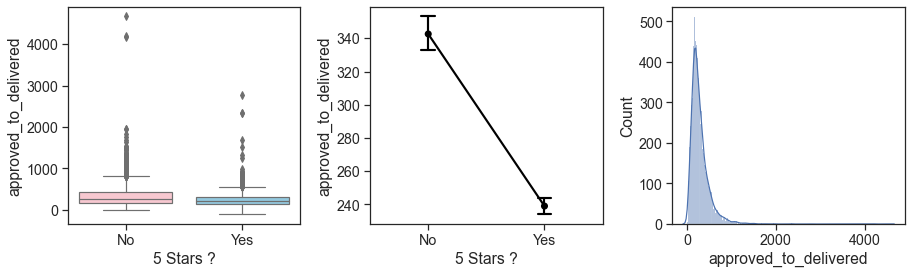

Mean(SD) for 'Yes' in 5 Star Rating? : 239.04(158.08)
Mean(SD) for 'No' in 5 Star Rating? : 342.60(282.33)
----------------------------------------------------------------------------------------------------


In [21]:
#Plot Styling
sns.set_context("notebook", font_scale=1.3, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
a = 1
for label in review_num_final.columns:
    print('\033[1m'+str(a)+'.', end=' ')
    print('\033[1m'+label.replace("_"," ").upper())
    #a.Plotting boxplot and point plot
    if label != 'label':
        fig, axs = plt.subplots(ncols=3, sharey = False, figsize = (15,4))

        f = sns.boxplot(x = 'label', y = label, data = review_num_final, ax=axs[0], palette=['pink', 'skyblue'])
        g = sns.pointplot(x = 'label', y = label, data = review_num_final, ax=axs[1], color='black', capsize=0.12)
        h = sns.histplot(x = label, data = review_num_final, kde=True, ax=axs[2])
        f.set_xlabel('5 Stars ?'); f.set_xticklabels(['No', 'Yes'], rotation=0)
        g.set_xlabel('5 Stars ?'); g.set_xticklabels(['No', 'Yes'], rotation=0)
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        plt.show()
        
        #b. Descriptive Analysis
        max_rating_yes = review_num_final.loc[review_num_final['label'] == 1, label]
        max_rating_no  = review_num_final.loc[review_num_final['label'] == 0, label]
        
        n_yes = max_rating_yes.shape[0]; n_no  = max_rating_no.shape[0]
        mean_yes = max_rating_yes.mean(); mean_no  = max_rating_no.mean()
        sd_yes = max_rating_yes.std(); sd_no  = max_rating_no.std()
        print("Mean(SD) for 'Yes' in 5 Star Rating? : {:.2f}({:.2f})".format(mean_yes, sd_yes))
        print("Mean(SD) for 'No' in 5 Star Rating? : {:.2f}({:.2f})".format(mean_no, sd_no))
        
        print('-'*100); a += 1

<AxesSubplot:>

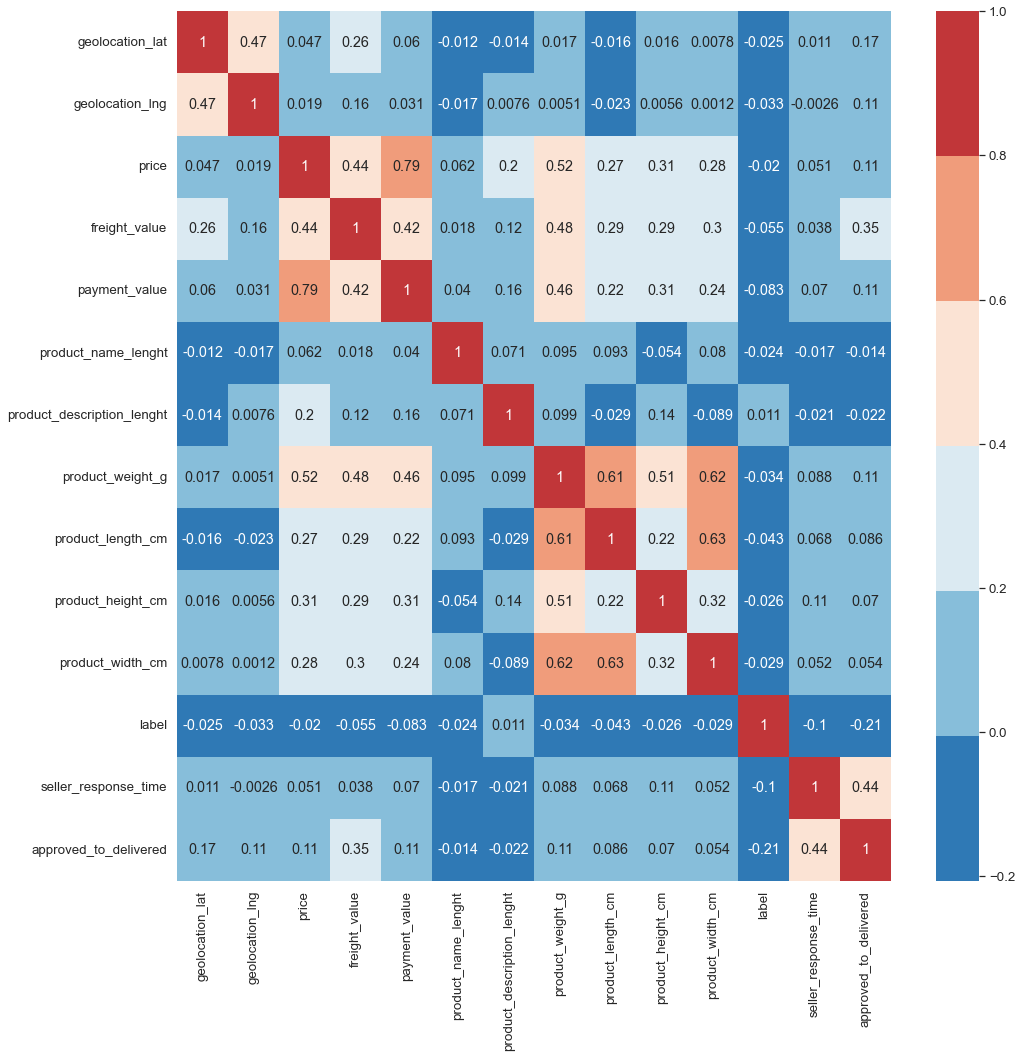

In [22]:
#Heatmap
corr = review_num_final.corr(method='spearman')
plt.figure(figsize=(16,16)); sns.set(font_scale = 1.2)
palette_heatmap = sns.color_palette("RdBu")
palette_heatmap.reverse()
sns.heatmap(corr, annot=True, cmap=palette_heatmap)

### **3. Categorical Features EDA**

In [23]:
cat_cols = [x for x in review_cleaned.columns if x not in review_num_final.columns]
cat_cols.append('label')

review_cleaned_cat = review_cleaned[cat_cols]
review_cleaned_cat.head()

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state,order_item_id,payment_sequential,payment_type,payment_installments,product_category_name,product_photos_qty,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,label
0,36570,vicosa,MG,36570,vicosa,MG,1,1,credit_card,8,pcs,4.0,42738,lauro de freitas,BA,computers,2017,10,43,4,0,0,0
1,72225,brasilia,DF,72225,brasilia,DF,1,1,credit_card,7,beleza_saude,1.0,80310,curitiba,PR,health_beauty,2017,12,50,0,0,0,0
2,13160,artur nogueira,SP,13160,artur nogueira,SP,1,1,credit_card,3,informatica_acessorios,1.0,87047,maringa,PR,computers_accessories,2018,2,7,4,0,0,0
3,15600,fernandopolis,SP,15600,fernandopolis,SP,1,1,credit_card,6,moveis_decoracao,1.0,3204,sao paulo,SP,furniture_decor,2018,1,1,6,0,0,0
4,29360,castelo,ES,29360,castelo,ES,1,1,credit_card,3,informatica_acessorios,1.0,87083,maringa,PR,computers_accessories,2017,7,30,0,0,0,1


In [24]:
unique_values(review_cleaned_cat)

Number of unique values for customer_zip_code_prefix : 2762
Number of unique values for customer_city : 863
Number of unique values for customer_state : 27
Number of unique values for geolocation_zip_code_prefix : 2762
Number of unique values for geolocation_city : 976
Number of unique values for geolocation_state : 27
Number of unique values for order_item_id : 11
Number of unique values for payment_sequential : 14
Number of unique values for payment_type : 4
Number of unique values for payment_installments : 18
Number of unique values for product_category_name : 67
Number of unique values for product_photos_qty : 17
Number of unique values for seller_zip_code_prefix : 1133
Number of unique values for seller_city : 361
Number of unique values for seller_state : 17
Number of unique values for product_category_name_english : 67
Number of unique values for order_purchase_year : 3
Number of unique values for order_purchase_month : 12
Number of unique values for order_purchase_week : 52
Nu

[(0.0, 0.5)]

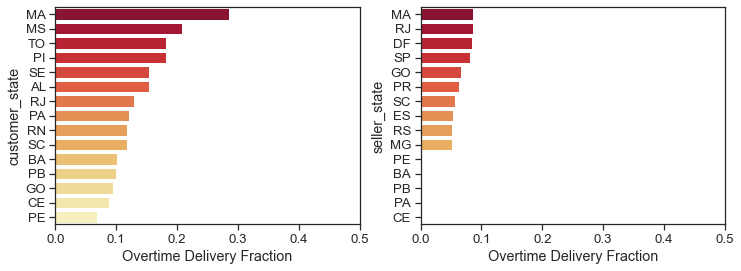

In [26]:
# Customer and seller state on how frequent its order got overtime delivery
sns.set_theme(style="ticks")
palette = sns.color_palette("YlOrRd", n_colors=15)
palette.reverse()
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})

fig, axs = plt.subplots(ncols=2, sharey = False, figsize = (12,4))

c_state = pd.crosstab(review_cleaned_cat['customer_state'], review_cleaned_cat['overtime_delivered'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[:15]
s_state = pd.crosstab(review_cleaned_cat['seller_state'], review_cleaned_cat['overtime_delivered'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[:15]
          
f = sns.barplot(x=1, y="customer_state", data=c_state, palette=palette, ax=axs[0])
g = sns.barplot(x=1, y="seller_state", data=s_state, palette=palette, ax=axs[1])
f.set_xlabel('Overtime Delivery Fraction'); f.set(xlim=(0,0.5))
g.set_xlabel('Overtime Delivery Fraction'); g.set(xlim=(0,0.5))

[(0.0, 0.5)]

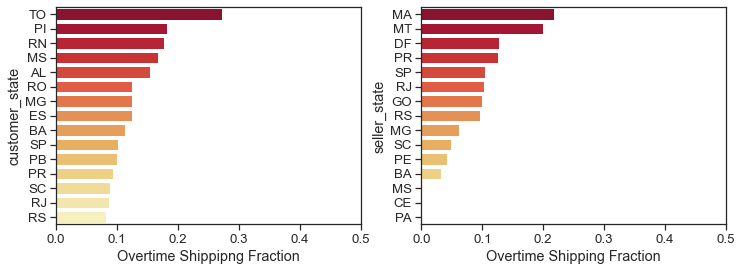

In [27]:
# Customer and seller state on how frequent its order got overtime shipping
sns.set_theme(style="ticks")
palette = sns.color_palette("YlOrRd", n_colors=15)
palette.reverse()
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
fig, axs = plt.subplots(ncols=2, sharey = False, figsize = (12,4))

c_state = pd.crosstab(review_cleaned_cat['customer_state'], review_cleaned_cat['overtime_shipping'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[:15]
s_state = pd.crosstab(review_cleaned_cat['seller_state'], review_cleaned_cat['overtime_shipping'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[:15]
          
f = sns.barplot(x=1, y="customer_state", data=c_state, palette=palette, ax=axs[0])
g = sns.barplot(x=1, y="seller_state", data=s_state, palette=palette, ax=axs[1])
f.set_xlabel('Overtime Shippipng Fraction'); f.set(xlim=(0,0.5))
g.set_xlabel('Overtime Shipping Fraction'); g.set(xlim=(0,0.5))

[(0.0, 1.0)]

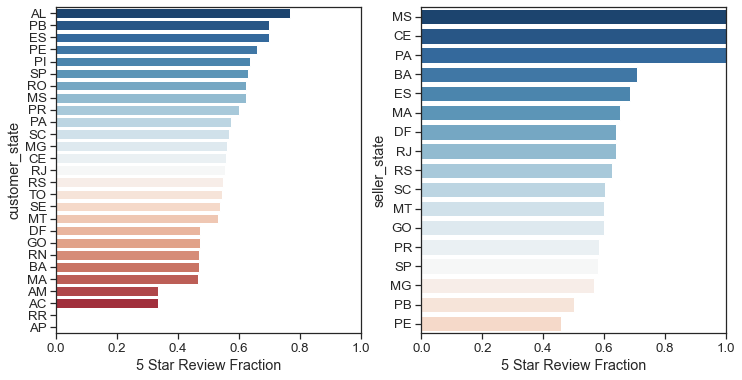

In [28]:
# How frequent does any customer and seller state got 5-star review?
sns.set_theme(style="ticks")
palette = sns.color_palette('RdBu', n_colors=27)
palette.reverse()
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
fig, axs = plt.subplots(ncols=2, sharey = False, figsize = (12,6))

c_state = pd.crosstab(review_cleaned_cat['customer_state'], review_cleaned_cat['label'], normalize='index').\
          reset_index().sort_values(1, ascending=False)
s_state = pd.crosstab(review_cleaned_cat['seller_state'], review_cleaned_cat['label'], normalize='index').\
          reset_index().sort_values(1, ascending=False)
          
f = sns.barplot(x=1, y="customer_state", data=c_state, palette=palette, ax=axs[0])
g = sns.barplot(x=1, y="seller_state", data=s_state, palette=palette, ax=axs[1])
f.set_xlabel('5 Star Review Fraction'); f.set(xlim=(0,1))
g.set_xlabel('5 Star Review Fraction'); g.set(xlim=(0,1))

[(0.0, 1.0)]

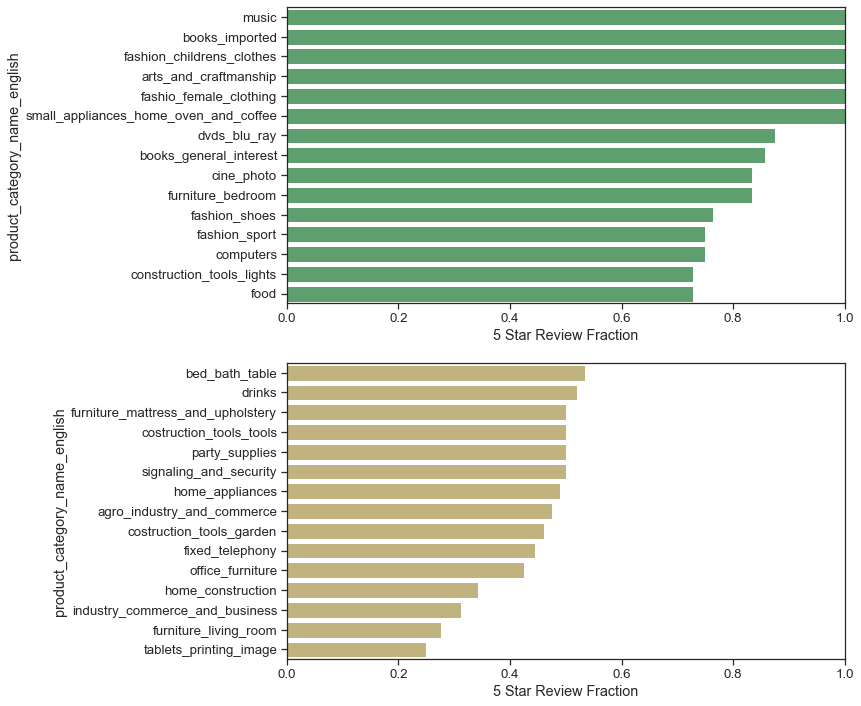

In [575]:
# How frequent does any product categories got 5-star review?
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.2, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})

fig, axs = plt.subplots(nrows=2, sharey = False, figsize = (10,12))

c_state = pd.crosstab(review_cleaned_cat['product_category_name_english'], review_cleaned_cat['label'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[:15]
s_state = pd.crosstab(review_cleaned_cat['product_category_name_english'], review_cleaned_cat['label'], normalize='index').\
          reset_index().sort_values(1, ascending=False).iloc[-15:]
          
f = sns.barplot(x=1, y="product_category_name_english", data=c_state, color='g', ax=axs[0])
g = sns.barplot(x=1, y="product_category_name_english", data=s_state, color='y', ax=axs[1])
f.set_xlabel('5 Star Review Fraction'); f.set(xlim=(0,1))
g.set_xlabel('5 Star Review Fraction'); g.set(xlim=(0,1))

In [31]:
# Is customer state and geological state the same?
same = (review_cleaned_cat['customer_state'] == review_cleaned_cat['geolocation_state']).astype('int')
same.unique() #We know that we can drop either customer_state or geolocation_state

array([1])

In [32]:
#Categorical columns to be aggregated
oid_vc = review_cleaned_num.value_counts('order_item_id')
ps_vc  = review_cleaned_num.value_counts('payment_sequential')
pi_vc  = review_cleaned_num.value_counts('payment_installments')
pc_vs  = review_cleaned_num.value_counts('product_photos_qty')

agg = pd.concat([oid_vc, ps_vc, pi_vc,  pc_vs], axis=1).fillna(0).astype('int')
agg.columns = ['order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty']
agg

,order_item_id,payment_sequential,payment_installments,product_photos_qty
1.0,5855,6431,3377,3471
2.0,599,165,777,1339
3.0,153,54,670,707
4.0,59,20,469,499
5.0,27,16,352,303
6.0,13,6,237,214
7.0,3,4,111,93
8.0,2,4,269,40
9.0,0,3,39,11
10.0,1,2,395,20


**From all three of those features we can aggregate it above a certain value, which is :**
1. 6 and above for order_item_id
2. 6 and above for payment_sequential
3. 9 and above for payment_installments
4. 8 and above for product_photos_qty

### **4. Business Insight EDA**

In [677]:
review_cleaned.head(3)

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,label,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,36570,vicosa,MG,36570,-20.751405,-42.824725,vicosa,MG,1,1437.0,42.51,1,credit_card,8,1479.51,pcs,55.0,3611.0,4.0,2750,16,31,39,42738,lauro de freitas,BA,computers,0,2017,10,43,4,0,0,102.612222,242.773333
1,72225,brasilia,DF,72225,-15.817357,-48.113121,brasilia,DF,1,349.9,22.85,1,credit_card,7,372.75,beleza_saude,51.0,625.0,1.0,900,25,12,38,80310,curitiba,PR,health_beauty,0,2017,12,50,0,0,0,9.331111,366.035278
2,13160,artur nogueira,SP,13160,-22.577270,-47.170631,artur nogueira,SP,1,69.9,12.62,1,credit_card,3,82.52,informatica_acessorios,51.0,518.0,1.0,214,18,14,13,87047,maringa,PR,computers_accessories,0,2018,2,7,4,0,0,90.855556,475.426389


#### **Transaction Value Growth**

In [680]:
query1 = review_cleaned.groupby('order_purchase_year')['payment_value'].sum().reset_index()
query1 = query1[query1['order_purchase_year'] >2016]
query1

,order_purchase_year,payment_value
1,2017,516611.75
2,2018,640195.73


#### **Total Transaction by State**

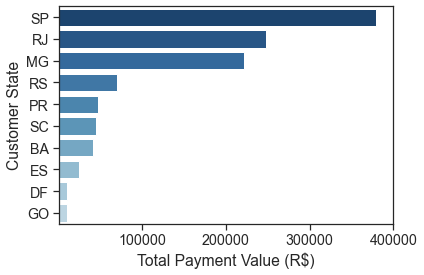

In [719]:
query2 = review_cleaned.groupby('customer_state')['payment_value'].sum().reset_index()
query2 = query2.sort_values('payment_value', ascending=False).reset_index().iloc[:10]

f = sns.barplot(x = 'payment_value', y="customer_state", data=query2, palette=palette)
f.set_xlabel('Total Payment Value (R$)'); f.set_ylabel('Customer State')
f.set_xticks(np.arange(100000, 500000, 100000))

#### **Total Transaction History**

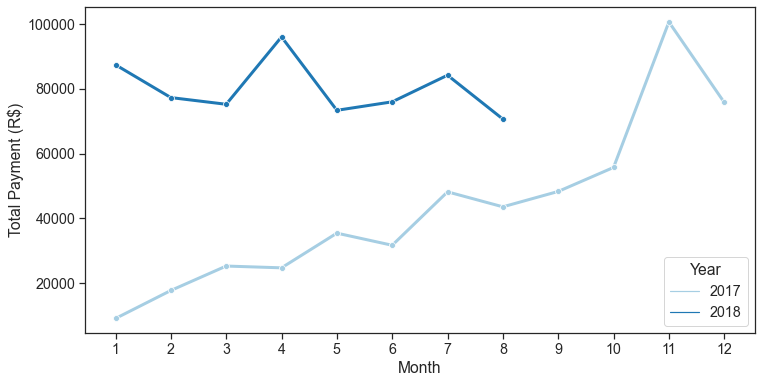

In [710]:
query3 = review_cleaned.groupby(['order_purchase_year', 'order_purchase_month'])['payment_value'].sum().reset_index()
query3 = query3[query3['order_purchase_year'] >2016]

sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.3, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 6.0,})
plt.figure(figsize=(12,6))
sns.lineplot(data=query3, x='order_purchase_month', y='payment_value', hue='order_purchase_year',marker='o', palette='Paired', lw=3)
plt.ylabel('Total Payment (R$)'); plt.xlabel('Month'); plt.xticks(np.arange(1,13,1))
plt.legend(title='Year')

#### **Order Transaction Value Distribution**

Text(0.5, 0, 'Price (R$)')

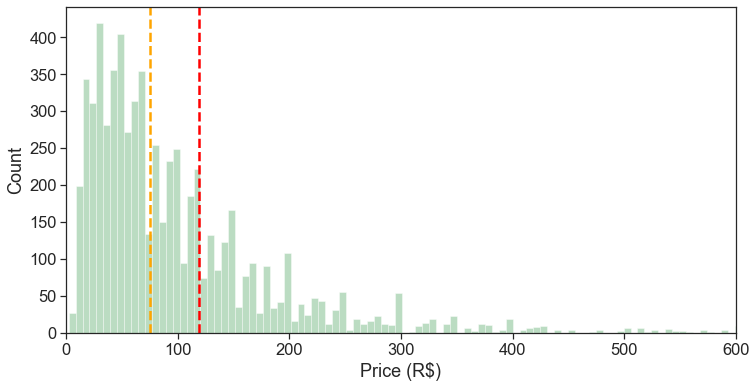

In [729]:
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.5, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
plt.figure(figsize=(12,6))
sns.distplot(review_cleaned['price'], bins=500 ,kde=False, color='g')
plt.axvline(np.median(review_cleaned['price']), c='orange', linestyle = '--', lw=2.5)
plt.axvline(np.mean(review_cleaned['price']), c='red', linestyle = '--', lw=2.5)
plt.xlim([0, 600]); plt.ylabel('Count'); plt.xlabel('Price (R$)')

#### **Most Frequent Product Categories Sold**

In [731]:
review_cleaned['product_category_name_english'].value_counts().reset_index().iloc[:7] 

,index,product_category_name_english
0,bed_bath_table,761
1,health_beauty,572
2,sports_leisure,535
3,furniture_decor,526
4,computers_accessories,510
5,housewares,439
6,watches_gifts,315


#### **Average Delivery Time on State with The Highest Transaction Value**

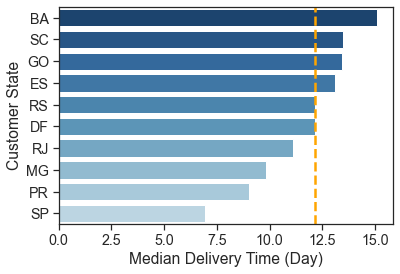

In [728]:
query4 = review_cleaned.groupby(['customer_state'])['approved_to_delivered'].median().reset_index()
query4['approved_to_delivered'] = query4['approved_to_delivered']/24 
query4 = query4[query4['customer_state'].isin(list(query2['customer_state']))]
query4 = query4.sort_values('approved_to_delivered', ascending=False).reset_index(drop=True)

g = sns.barplot(x = 'approved_to_delivered', y="customer_state", data=query4, palette=palette)
g.set_xlabel('Median Delivery Time (Day)'); g.set_ylabel('Customer State')
plt.axvline(np.median(query4['approved_to_delivered']), c='orange', linestyle = '--', lw=2.5)
#g.set_xticks(np.arange(100000, 500000, 100000))

#### **Payment Method Distribution**

In [724]:
query5 = review_cleaned.value_counts('payment_type').reset_index()
query5

,payment_type,0
0,credit_card,4911
1,boleto,1353
2,voucher,358
3,debit_card,92


# **2. Feature Engineering**

In [34]:
review_cleaned.head(3)

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,label,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,36570,vicosa,MG,36570,-20.751405,-42.824725,vicosa,MG,1,1437.0,42.51,1,credit_card,8,1479.51,pcs,55.0,3611.0,4.0,2750,16,31,39,42738,lauro de freitas,BA,computers,0,2017,10,43,4,0,0,102.612222,242.773333
1,72225,brasilia,DF,72225,-15.817357,-48.113121,brasilia,DF,1,349.9,22.85,1,credit_card,7,372.75,beleza_saude,51.0,625.0,1.0,900,25,12,38,80310,curitiba,PR,health_beauty,0,2017,12,50,0,0,0,9.331111,366.035278
2,13160,artur nogueira,SP,13160,-22.577270,-47.170631,artur nogueira,SP,1,69.9,12.62,1,credit_card,3,82.52,informatica_acessorios,51.0,518.0,1.0,214,18,14,13,87047,maringa,PR,computers_accessories,0,2018,2,7,4,0,0,90.855556,475.426389


## **Label Balance & Data Split**

In [35]:
#Label balance check
review_cleaned.label.value_counts()

1    3931
0    2783
Name: label, dtype: int64

**Label feature has good distribution between 1 and 0, therefore we don't need to adjust it with undersampling/oversampling**

In [36]:
X = review_cleaned.drop('label', axis=1)
y = review_cleaned.label

In [37]:
#Splitting X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=143, stratify = y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4699, 35) (4699,)
(2015, 35) (2015,)


## **1. Numerical FE**

In [95]:
# Selecting numerical columns
num_cols = list(review_num_final.columns); num_cols.remove('label')
X_train_num = X_train.loc[:,num_cols]
X_train_num.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
214,-23.537729,-46.885263,13.99,7.78,21.77,54.0,935.0,50,16,5,11,16.482500,37.080556
452,-23.687118,-49.825884,47.65,18.23,65.88,40.0,409.0,1110,19,11,18,159.291944,313.042778
938,-20.667206,-43.800459,199.00,27.71,226.71,63.0,457.0,4750,61,12,38,45.581111,155.106111


### **Transformation**

**From EDA we know that :**
* All numerical features (except geolocation_lat and geolocation_lng) have highly skewed distribution.<br>
* All numerical features also have pretty significant ammount of outliers that need to be treated.<br>

#### **Winsonrizing Geolocation lat and lng**

This is done to minimize the ammount of outliers

In [96]:
geo_num = list(X_train_num.columns)[:2]
for col in geo_num:
    X_train_num[col] = winsorize(X_train_num[col], (0.01,0.05))

#### **Transforming Skewed Data**
This is done to treat skewness while also reducing the amount of outliers

In [97]:
#Transformation related function
def log_transform_custom(x):
    if x<0:
        y = -np.log10(-x+1)
    else:
        y = np.log10(x+1)
    return y
def square_transform(x):
    y = x*x
    return y

def std_outliers(df): #+- 3 STD is used as critical value
    # calculate summary statistics
    data_mean, data_std = df.mean(), df.std()
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in df if x < lower or x > upper]
    return len(outliers)


1. GEOLOCATION LAT


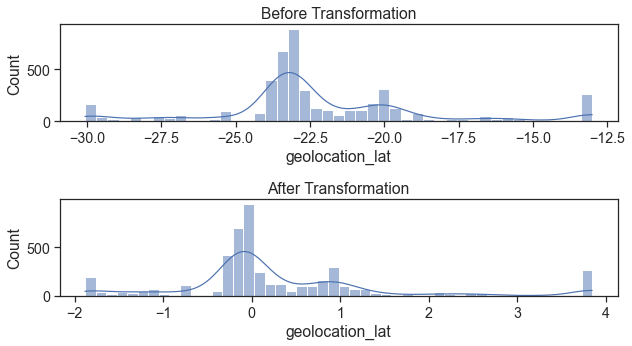

Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
2. GEOLOCATION LNG


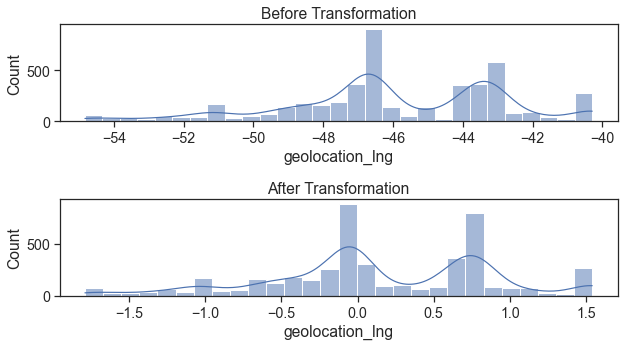

Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
3. PRICE


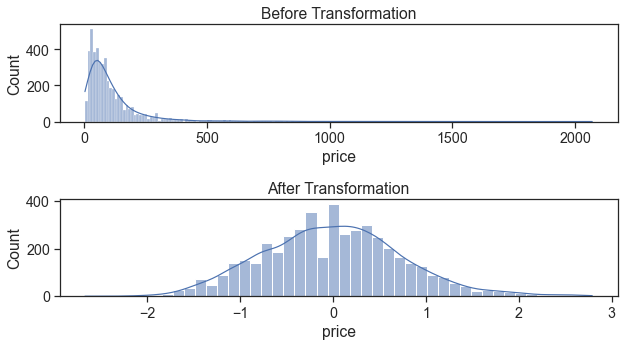

Numbers of outlier before transformation : 85
Numbers of outlier after transformation : 28
----------------------------------------------------------------------------------------------------
4. FREIGHT VALUE


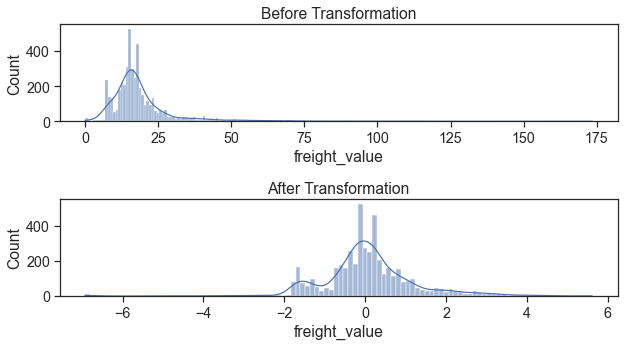

Numbers of outlier before transformation : 104
Numbers of outlier after transformation : 74
----------------------------------------------------------------------------------------------------
5. PAYMENT VALUE


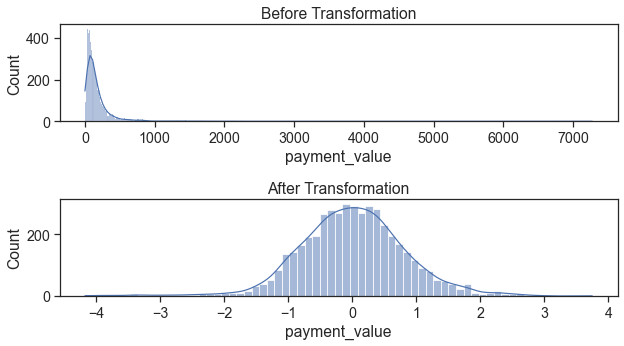

Numbers of outlier before transformation : 64
Numbers of outlier after transformation : 53
----------------------------------------------------------------------------------------------------
6. PRODUCT NAME LENGHT


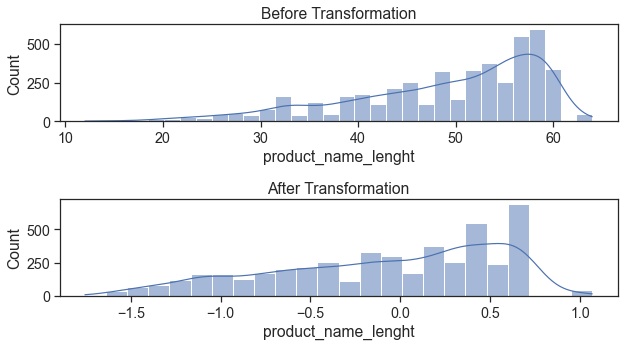

Numbers of outlier before transformation : 23
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
7. PRODUCT DESCRIPTION LENGHT


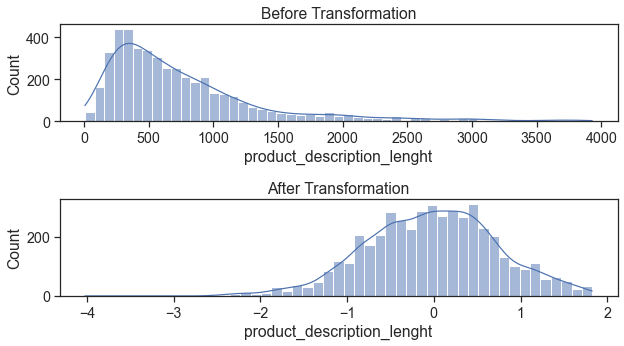

Numbers of outlier before transformation : 111
Numbers of outlier after transformation : 9
----------------------------------------------------------------------------------------------------
8. PRODUCT WEIGHT G


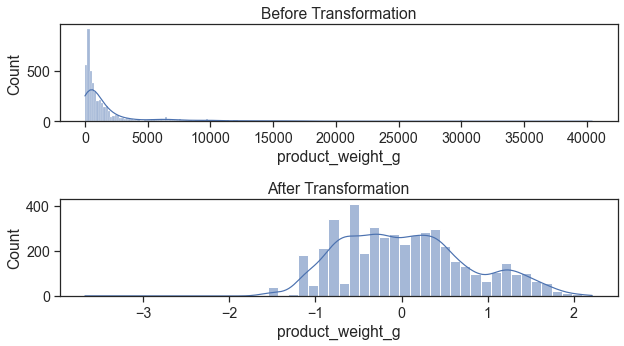

Numbers of outlier before transformation : 120
Numbers of outlier after transformation : 2
----------------------------------------------------------------------------------------------------
9. PRODUCT LENGTH CM


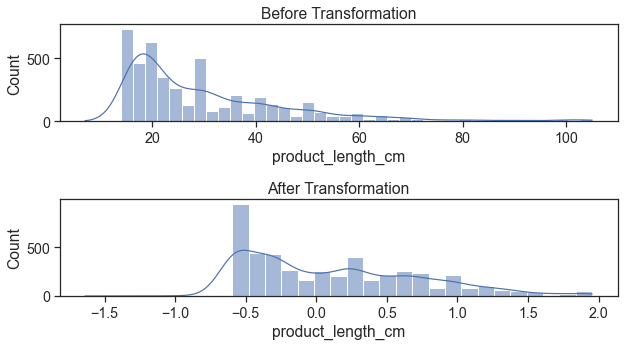

Numbers of outlier before transformation : 93
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
10. PRODUCT HEIGHT CM


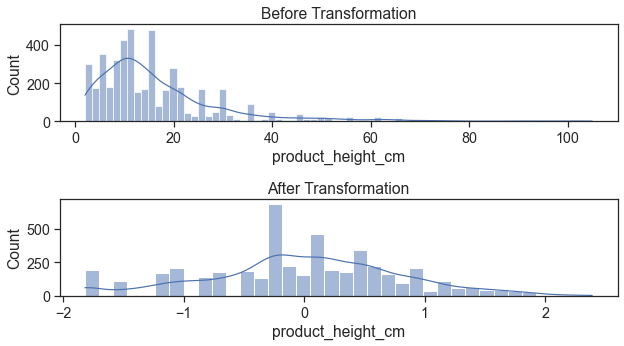

Numbers of outlier before transformation : 100
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
11. PRODUCT WIDTH CM


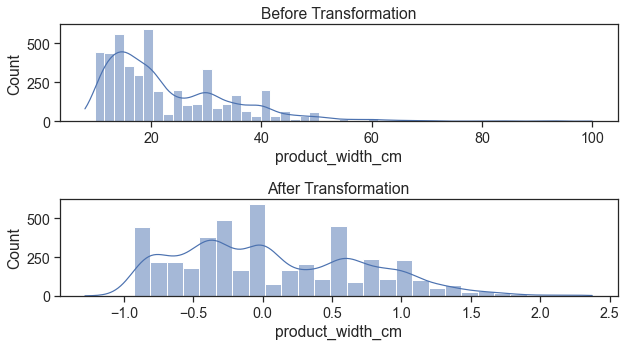

Numbers of outlier before transformation : 75
Numbers of outlier after transformation : 18
----------------------------------------------------------------------------------------------------
12. SELLER RESPONSE TIME


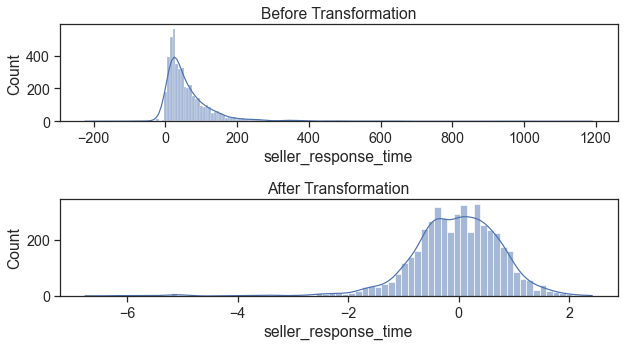

Numbers of outlier before transformation : 101
Numbers of outlier after transformation : 58
----------------------------------------------------------------------------------------------------
13. APPROVED TO DELIVERED


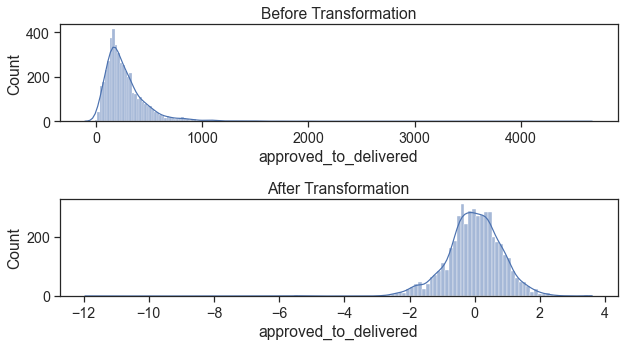

Numbers of outlier before transformation : 68
Numbers of outlier after transformation : 17
----------------------------------------------------------------------------------------------------


In [99]:
#Checking the efectiveness of transformation in reducing outliers
sns.set_context("notebook", font_scale=1.3, rc={'axes.grid': True, 'lines.linewidth': 1.2, 'lines.markersize': 3.0,})
a = 1
X_train_num_transformed = X_train_num.copy()
scaler = RobustScaler()
#Transforming data
for col in X_train_num.columns:
    if col == 'product_name_lenght':
        X_train_num_transformed[col] = X_train_num[col].apply(square_transform)
    else:
        X_train_num_transformed[col] = X_train_num[col].apply(log_transform_custom)
        
#Scaling all data
X_train_num_transformed = pd.DataFrame(scaler.fit_transform(X_train_num_transformed), 
                                       columns = scaler.feature_names_in_,
                                       index = list(X_train_num_transformed.index) )

#Visualizing transformation results
for col in X_train_num.columns:
    print('\033[1m'+str(a)+'.', end=' ')
    print('\033[1m'+col.replace("_"," ").upper())

    #a.Plotting boxplot and point plot
    fig, axs = plt.subplots(nrows=2, sharey = False, figsize = (10,5))
    f = sns.histplot(x = col, data = X_train_num, kde=True, ax=axs[0]).set(title='Before Transformation')
    g = sns.histplot(x = col, data = X_train_num_transformed, kde=True, ax=axs[1]).set(title='After Transformation')
    
    plt.subplots_adjust(hspace=0.8)
    plt.show()
    
    print('Numbers of outlier before transformation : {}'.format(std_outliers(X_train_num[col])))
    print('Numbers of outlier after transformation : {}'.format(std_outliers(X_train_num_transformed[col])))
    print('-'*100); a += 1

In [100]:
scaler.feature_names_in_

array(['geolocation_lat', 'geolocation_lng', 'price', 'freight_value',
       'payment_value', 'product_name_lenght',
       'product_description_lenght', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_response_time', 'approved_to_delivered'], dtype=object)

In [101]:
X_train_num_transformed.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
214,-0.184975,-0.094736,-1.368728,-1.651252,-1.394168,0.225000,0.445713,-1.491913,-0.590835,-1.000000,-0.846110,-0.684875,-2.111694
452,-0.228588,-0.752236,-0.375308,0.254255,-0.433640,-0.715000,-0.348601,0.217227,-0.364839,-0.181932,-0.151321,0.943782,0.396629
938,0.708967,0.639897,0.817592,1.228339,0.658575,0.977143,-0.242066,1.023260,1.208470,-0.087464,0.935955,0.035442,-0.434388


## **2. Categorical FE**

In [102]:
cat_cols = list(review_cleaned_cat.columns)
#We drop zip code prefix since we're going to use latitude-longitude coords as their substitute
cat_del  = ['label', 'customer_zip_code_prefix', 'seller_zip_code_prefix', 'order_purchase_year', 
            'geolocation_zip_code_prefix', 'geolocation_state', 'product_category_name']
cat_cols = [e for e in cat_cols if e not in (cat_del)]
# Selecting categorical columns 
X_train_cat = X_train.loc[:,cat_cols]
X_train_cat.product_photos_qty = X_train_cat.product_photos_qty.astype('int')
X_train_cat.head(3)

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_type,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered
214,barueri,SP,barueri,1,1,boleto,1,1,sao paulo,SP,perfumery,11,47,6,0,0
452,siqueira campos,PR,siqueira campos,1,1,credit_card,3,1,indaiatuba,SP,health_beauty,3,12,1,1,0
938,conselheiro lafaiete,MG,conselheiro lafaiete,1,1,boleto,1,5,sao carlos,SP,housewares,1,2,1,0,0


### **New Features**

In [103]:
#Investigating Customer-Seller Location Similarities
compare = pd.DataFrame()
compare['state_same?'] = review_cleaned['customer_state'] == review_cleaned['seller_state'] 
compare['city_same?'] = review_cleaned['customer_city'] == review_cleaned['seller_city'] 
compare['zip_code_same?'] = review_cleaned['customer_zip_code_prefix'] == review_cleaned['seller_zip_code_prefix'] 

for col in compare.columns:
    print(compare[[col]].value_counts(normalize=True)*100)

state_same?
False          66.711349
True           33.288651
dtype: float64
city_same?
False         95.948764
True           4.051236
dtype: float64
zip_code_same?
False             99.970211
True               0.029789
dtype: float64


From above investigation **I wanted to try adding two features** indicating whether seller and customer city and/or state is the same or not, designated as 'state_same?' and 'city_same?'

In [104]:
X_train_cat['state_same?'] = (X_train_cat['customer_state'] == X_train_cat['seller_state']).astype('int')
X_train_cat['city_same?']  = (X_train_cat['customer_city'] == X_train_cat['seller_city']).astype('int')

In [105]:
X_train_cat.shape

(4699, 18)

### **Cardinality Separation**

In [106]:
# Determines which features need to be encoded using frequency encoding or OHE
freq_enc_cols = []
ohe_enc_cols  = []
for col in X_train_cat.columns:
    if (len(X_train_cat[col].unique())<=5) and (len(X_train_cat[col].unique())>2): # OHE
        ohe_enc_cols.append(col)
    elif len(X_train_cat[col].unique())!=2: # Frequency encoding (High cardinality)
        freq_enc_cols.append(col)
        
print(ohe_enc_cols)
print(freq_enc_cols)

['payment_type']
['customer_city', 'customer_state', 'geolocation_city', 'order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty', 'seller_city', 'seller_state', 'product_category_name_english', 'order_purchase_month', 'order_purchase_week', 'order_purchase_dayofweek']


### **Aggregation for Cardinality Reduction**

From the previous EDA we wanted to aggregate the values of several cols to reduce their cardinality.
1. 6 and above for order_item_id
2. 6 and above for payment_sequential
3. 9 and above for payment_installments
4. 8 and above for product_photos_qty

In [107]:
agg_cols = ['order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty']
agg_threshold = [6,6,9,8]
for i, col in enumerate(agg_cols):
    X_train_cat[col] = X_train_cat[col].apply(lambda x: agg_threshold[i] if x>= agg_threshold[i] else x)

We will also aggregate city, state and category name values that have **less than 0.5% frequency into 'Other' group**

In [108]:
agg_cols_other = ['customer_city', 'customer_state', 'geolocation_city', 'seller_city', 'seller_state', 'product_category_name_english']

for col in agg_cols_other:
    categories_list = [] # Container for cat freq. >0.5%
    freq_df = pd.DataFrame(X_train_cat.value_counts(col)/len(X_train_cat), columns=['frequency']).reset_index()
    #Getting all values above threshold freq. (0.5%)
    for value in freq_df[col].unique():
        if freq_df[freq_df[col]==value]['frequency'].item() > 0.005:
            categories_list.append(value)
    
    X_train_cat[col] = X_train_cat[col].apply(lambda x: x if x in categories_list else 'Other')

In [109]:
test_df = pd.DataFrame(X_train_cat.value_counts('seller_city')/len(X_train_cat))
test_df

,0
seller_city,
Other,0.301554
sao paulo,0.249628
ibitinga,0.076825
curitiba,0.028942
maringa,0.025112
sao jose do rio preto,0.024899
santo andre,0.024686
belo horizonte,0.022132
ribeirao preto,0.021494


In [110]:
#Unique values count after aggregation
unique_values(X_train_cat[freq_enc_cols])

Number of unique values for customer_city : 33
Number of unique values for customer_state : 14
Number of unique values for geolocation_city : 31
Number of unique values for order_item_id : 6
Number of unique values for payment_sequential : 6
Number of unique values for payment_installments : 9
Number of unique values for product_photos_qty : 8
Number of unique values for seller_city : 33
Number of unique values for seller_state : 9
Number of unique values for product_category_name_english : 26
Number of unique values for order_purchase_month : 12
Number of unique values for order_purchase_week : 52
Number of unique values for order_purchase_dayofweek : 7


### **OHE and Frequency Encoding**

In [111]:
X_train_cat_enc = X_train_cat.copy()

In [113]:
#One Hot Encoding
OHE = OneHotEncoder(handle_unknown='ignore')
payment_OHE = OHE.fit_transform(X_train_cat_enc['payment_type'].to_numpy().reshape(-1,1)).toarray()
df_payment_OHE = pd.DataFrame(payment_OHE, 
                              columns=list(X_train_cat_enc['payment_type'].unique()), 
                              index=list(X_train_cat_enc.index))

X_train_cat_enc = X_train_cat_enc.drop('payment_type', axis=1)
X_train_cat_enc = pd.concat([X_train_cat_enc, df_payment_OHE], axis=1)

In [114]:
#Frequency Encoding
for col in freq_enc_cols:
    freq_dict = {}
    freq_df = pd.DataFrame(X_train_cat_enc.value_counts(col)/len(X_train_cat_enc), columns=['frequency']).reset_index()
    #Assigning frequency to each categorical values
    for value in freq_df[col].unique():
        freq_dict[value] = freq_df[freq_df[col]==value]['frequency'].item()
    
    X_train_cat_enc[col] = X_train_cat_enc[col].apply(lambda x: freq_dict[x])

In [115]:
X_train_cat_enc.head(3)

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
214,0.005746,0.373058,0.005746,0.870185,0.956587,0.497978,0.514578,0.249628,0.703341,0.032986,0.075335,0.034688,0.126623,0,0,1,0,1.0,0.0,0.0,0.0
452,0.470526,0.040221,0.503937,0.870185,0.956587,0.099383,0.514578,0.301554,0.703341,0.087465,0.096403,0.026601,0.159396,1,0,0,0,0.0,1.0,0.0,0.0
938,0.470526,0.190253,0.503937,0.870185,0.956587,0.497978,0.043626,0.301554,0.703341,0.065971,0.079804,0.017451,0.159396,0,0,0,0,1.0,0.0,0.0,0.0


## **Joining Transformed Data**

In [117]:
X_train_transformed = pd.concat([X_train_num_transformed, X_train_cat_enc], axis=1)
print(X_train_transformed.shape)
X_train_transformed.head(3)

(4699, 34)


,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
214,-0.184975,-0.094736,-1.368728,-1.651252,-1.394168,0.225000,0.445713,-1.491913,-0.590835,-1.000000,-0.846110,-0.684875,-2.111694,0.005746,0.373058,0.005746,0.870185,0.956587,0.497978,0.514578,0.249628,0.703341,0.032986,0.075335,0.034688,0.126623,0,0,1,0,1.0,0.0,0.0,0.0
452,-0.228588,-0.752236,-0.375308,0.254255,-0.433640,-0.715000,-0.348601,0.217227,-0.364839,-0.181932,-0.151321,0.943782,0.396629,0.470526,0.040221,0.503937,0.870185,0.956587,0.099383,0.514578,0.301554,0.703341,0.087465,0.096403,0.026601,0.159396,1,0,0,0,0.0,1.0,0.0,0.0
938,0.708967,0.639897,0.817592,1.228339,0.658575,0.977143,-0.242066,1.023260,1.208470,-0.087464,0.935955,0.035442,-0.434388,0.470526,0.190253,0.503937,0.870185,0.956587,0.497978,0.043626,0.301554,0.703341,0.065971,0.079804,0.017451,0.159396,0,0,0,0,1.0,0.0,0.0,0.0


## **3. Test Set Transformation**

In [118]:
X_test.head(3)

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
5334,14402,franca,SP,14402,-20.519389,-47.374210,franca,SP,2,34.99,15.10,1,credit_card,1,100.18,ferramentas_jardim,59.0,2407.0,1.0,400,38,10,25,89204,joinville,SC,garden_tools,2017,7,29,0,0,0,20.756944,240.872222
2092,3344,sao paulo,SP,3344,-23.558422,-46.576222,são paulo,SP,1,125.00,15.98,1,credit_card,2,140.98,beleza_saude,52.0,1151.0,1.0,300,16,20,15,83010,sao jose dos pinhais,PR,health_beauty,2018,6,24,2,0,0,1.754722,54.904722
1274,80630,curitiba,PR,80630,-25.471187,-49.270525,curitiba,PR,1,89.99,15.39,1,credit_card,8,105.38,beleza_saude,59.0,492.0,3.0,250,22,10,18,9015,santo andre,SP,health_beauty,2018,1,3,3,0,0,28.609167,216.785278


### **Numerical Transformation**

In [119]:
X_test_num = X_test.loc[:, list(X_train_num.columns)]
X_test_num.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
5334,-20.519389,-47.374210,34.99,15.10,100.18,59.0,2407.0,400,38,10,25,20.756944,240.872222
2092,-23.558422,-46.576222,125.00,15.98,140.98,52.0,1151.0,300,16,20,15,1.754722,54.904722
1274,-25.471187,-49.270525,89.99,15.39,105.38,59.0,492.0,250,22,10,18,28.609167,216.785278


In [120]:
#Winsorizing geologication cols
for col in geo_num:
    X_test_num[col] = winsorize(X_test_num[col], (0.01,0.05))

In [122]:
#Checking the efectiveness of transformation in reducing outliers
X_test_num_transformed = X_test_num.copy()
a=1
#Transforming data
for col in X_test_num.columns:
    if col == 'product_name_lenght':
        X_test_num_transformed[col] = X_test_num[col].apply(square_transform)
    else:
        X_test_num_transformed[col] = X_test_num[col].apply(log_transform_custom)
#Scaling all data
X_test_num_transformed = pd.DataFrame(scaler.transform(X_test_num_transformed), 
                                       columns = scaler.feature_names_in_,
                                       index = list(X_test_num_transformed.index) )
for col in X_test_num.columns:
    print('\033[1m'+str(a)+'.', end=' ')
    print('\033[1m'+col.replace("_"," ").upper())
    
    print('Numbers of outlier before transformation : {}'.format(std_outliers(X_test_num[col])))
    print('Numbers of outlier after transformation : {}'.format(std_outliers(X_test_num_transformed[col])))
    print('-'*100); a += 1

1. GEOLOCATION LAT
Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
2. GEOLOCATION LNG
Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
3. PRICE
Numbers of outlier before transformation : 34
Numbers of outlier after transformation : 19
----------------------------------------------------------------------------------------------------
4. FREIGHT VALUE
Numbers of outlier before transformation : 48
Numbers of outlier after transformation : 32
----------------------------------------------------------------------------------------------------
5. PAYMENT VALUE
Numbers of outlier before transformation : 39
Numbers of outlier after transformation : 26
----------------------------------------------------------------

In [123]:
X_test_num_transformed.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
5334,0.786541,-0.219731,-0.636348,-0.222158,-0.106556,0.555,1.286025,-0.345438,0.607139,-0.197161,0.322913,-0.527038,0.044661
2092,-0.199138,-0.037793,0.430379,-0.087723,0.191879,0.000,0.611848,-0.503364,-0.636215,0.566003,-0.411150,-1.991537,-1.761588
1274,-0.758772,-0.640316,0.153250,-0.177060,-0.062408,0.555,-0.164237,-0.603375,-0.183583,-0.197161,-0.151321,-0.308669,-0.084695


### **Categorical Transformation**

In [125]:
X_test_cat = X_test.loc[:,cat_cols]
X_test_cat.head(3)

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_type,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered
5334,franca,SP,franca,2,1,credit_card,1,1.0,joinville,SC,garden_tools,7,29,0,0,0
2092,sao paulo,SP,são paulo,1,1,credit_card,2,1.0,sao jose dos pinhais,PR,health_beauty,6,24,2,0,0
1274,curitiba,PR,curitiba,1,1,credit_card,8,3.0,santo andre,SP,health_beauty,1,3,3,0,0


In [126]:
X_test_cat.shape

(2015, 16)

In [127]:
#Adding Features
X_test_cat['state_same?'] = (X_test_cat['customer_state'] == X_test_cat['seller_state']).astype('int')
X_test_cat['city_same?']  = (X_test_cat['customer_city'] == X_test_cat['seller_city']).astype('int')

In [128]:
#Aggregating values #1
agg_cols = ['order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty']
agg_threshold = [6,6,9,8]
for i, col in enumerate(agg_cols):
    X_test_cat[col] = X_test_cat[col].apply(lambda x: agg_threshold[i] if x>= agg_threshold[i] else x)

In [129]:
#Aggregating values #2 (Other)
agg_cols_other = ['customer_city', 'customer_state', 'geolocation_city', 'seller_city', 'seller_state', 'product_category_name_english']
for col in agg_cols_other:
    categories_list = list(X_train_cat[col].unique())
    categories_list.remove('Other')
    
    X_test_cat[col] = X_test_cat[col].apply(lambda x: x if x in categories_list else 'Other')

#### **OHE and Frequency Encoding**

In [130]:
X_test_cat_enc = X_test_cat.copy()

In [131]:
#One Hot Encoding
OHE = OneHotEncoder(handle_unknown='ignore')
payment_OHE = OHE.fit_transform(X_test_cat_enc['payment_type'].to_numpy().reshape(-1,1)).toarray()
df_payment_OHE = pd.DataFrame(payment_OHE, 
                              columns=list(X_test_cat_enc['payment_type'].unique()), 
                              index=list(X_test_cat_enc.index))

X_test_cat_enc = X_test_cat_enc.drop('payment_type', axis=1)
X_test_cat_enc = pd.concat([X_test_cat_enc, df_payment_OHE], axis=1)

In [133]:
#Frequency Encoding
for col in freq_enc_cols:
    freq_dict = {}
    freq_df = pd.DataFrame(X_train_cat.value_counts(col)/len(X_train_cat), columns=['frequency']).reset_index()
    #Assigning frequency to each categorical values
    for value in freq_df[col].unique():
        freq_dict[value] = freq_df[freq_df[col]==value]['frequency'].item()
    
    X_test_cat_enc[col] = X_test_cat_enc[col].apply(lambda x: freq_dict[x])

In [134]:
X_test_cat_enc1 = X_test_cat_enc.reindex(columns=list(X_train_cat_enc.columns))

In [139]:
X_test_cat_enc1.head()

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
5334,0.005107,0.373058,0.005107,0.090870,0.956587,0.497978,0.514578,0.009364,0.041073,0.038519,0.106618,0.030006,0.171313,0,0,0,0,1.0,0.0,0.0,0.0
2092,0.091083,0.373058,0.015748,0.870185,0.956587,0.114705,0.514578,0.301554,0.084486,0.087465,0.096616,0.027878,0.148329,0,0,0,0,1.0,0.0,0.0,0.0
1274,0.018515,0.040221,0.018515,0.870185,0.956587,0.041285,0.104065,0.024686,0.703341,0.087465,0.079804,0.017238,0.143860,0,0,0,0,1.0,0.0,0.0,0.0
2235,0.470526,0.059587,0.503937,0.870185,0.956587,0.099383,0.206214,0.009577,0.703341,0.023409,0.058523,0.021068,0.126623,0,0,0,0,1.0,0.0,0.0,0.0
4316,0.470526,0.373058,0.503937,0.870185,0.956587,0.114705,0.514578,0.249628,0.703341,0.076186,0.096403,0.025750,0.159396,0,0,1,0,1.0,0.0,0.0,0.0


### **Joining Transformed Data**

In [140]:
X_test_transformed = pd.concat([X_test_num_transformed, X_test_cat_enc1], axis=1)
print(X_test_transformed.shape)
X_test_transformed.head(3)

(2015, 34)


,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
5334,0.786541,-0.219731,-0.636348,-0.222158,-0.106556,0.555,1.286025,-0.345438,0.607139,-0.197161,0.322913,-0.527038,0.044661,0.005107,0.373058,0.005107,0.090870,0.956587,0.497978,0.514578,0.009364,0.041073,0.038519,0.106618,0.030006,0.171313,0,0,0,0,1.0,0.0,0.0,0.0
2092,-0.199138,-0.037793,0.430379,-0.087723,0.191879,0.000,0.611848,-0.503364,-0.636215,0.566003,-0.411150,-1.991537,-1.761588,0.091083,0.373058,0.015748,0.870185,0.956587,0.114705,0.514578,0.301554,0.084486,0.087465,0.096616,0.027878,0.148329,0,0,0,0,1.0,0.0,0.0,0.0
1274,-0.758772,-0.640316,0.153250,-0.177060,-0.062408,0.555,-0.164237,-0.603375,-0.183583,-0.197161,-0.151321,-0.308669,-0.084695,0.018515,0.040221,0.018515,0.870185,0.956587,0.041285,0.104065,0.024686,0.703341,0.087465,0.079804,0.017238,0.143860,0,0,0,0,1.0,0.0,0.0,0.0


## **4. Feature Selection**

In [303]:
#Manual Feature Selection (Based on EDA)
dropped_cols_manual =['geolocation_lat', 'geolocation_lng', 'price', 'freight_value', 'product_name_lenght',
                      'product_description_lenght', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                      'geolocation_city', 'order_purchase_dayofweek']
X_train_sel_manual = X_train_transformed.drop(dropped_cols_manual, axis=1)
X_test_sel_manual = X_test_transformed.drop(dropped_cols_manual, axis=1)

In [305]:
X_train_sel_manual.head()

,payment_value,product_weight_g,seller_response_time,approved_to_delivered,customer_city,customer_state,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
214,-1.394168,-1.491913,-0.684875,-2.111694,0.005746,0.373058,0.870185,0.956587,0.497978,0.514578,0.249628,0.703341,0.032986,0.075335,0.034688,0,0,1,0,1.0,0.0,0.0,0.0
452,-0.433640,0.217227,0.943782,0.396629,0.470526,0.040221,0.870185,0.956587,0.099383,0.514578,0.301554,0.703341,0.087465,0.096403,0.026601,1,0,0,0,0.0,1.0,0.0,0.0
938,0.658575,1.023260,0.035442,-0.434388,0.470526,0.190253,0.870185,0.956587,0.497978,0.043626,0.301554,0.703341,0.065971,0.079804,0.017451,0,0,0,0,1.0,0.0,0.0,0.0
5635,0.200271,0.730168,0.713699,0.710630,0.010641,0.373058,0.870185,0.956587,0.065759,0.514578,0.005746,0.703341,0.065971,0.096403,0.022984,0,0,1,0,0.0,1.0,0.0,0.0
838,0.378402,1.157424,-0.233487,0.194995,0.470526,0.373058,0.870185,0.956587,0.099383,0.514578,0.007236,0.079379,0.038519,0.079804,0.017238,0,0,0,0,0.0,1.0,0.0,0.0


In [315]:
#Using SelectKBest method for calculating mutual information
MI_df_manual = pd.DataFrame(mutual_info_classif(X_train_sel_manual, y_train, random_state=143), 
                            index=X_train_sel_manual.columns, 
                            columns=['mutual_info']).sort_values('mutual_info', ascending=False)

#Selecting columns (upper 75th quantile)
MI_df_manual = MI_df_manual[MI_df_manual['mutual_info'] > MI_df_manual['mutual_info'].quantile(.25)]
MI_df_manual

,mutual_info
seller_response_time,0.047380
approved_to_delivered,0.046131
customer_state,0.020787
payment_value,0.020521
city_same?,0.018041
overtime_delivered,0.016720
product_weight_g,0.016034
seller_state,0.013673
overtime_shipping,0.010586
state_same?,0.010117


In [317]:
#Final columns
X_train_mi_manual = X_train_transformed.loc[:,MI_df_manual.index].drop(['seller_city'], axis=1)
X_test_mi_manual = X_test_transformed.loc[:,MI_df_manual.index].drop(['seller_city'], axis=1)

<AxesSubplot:>

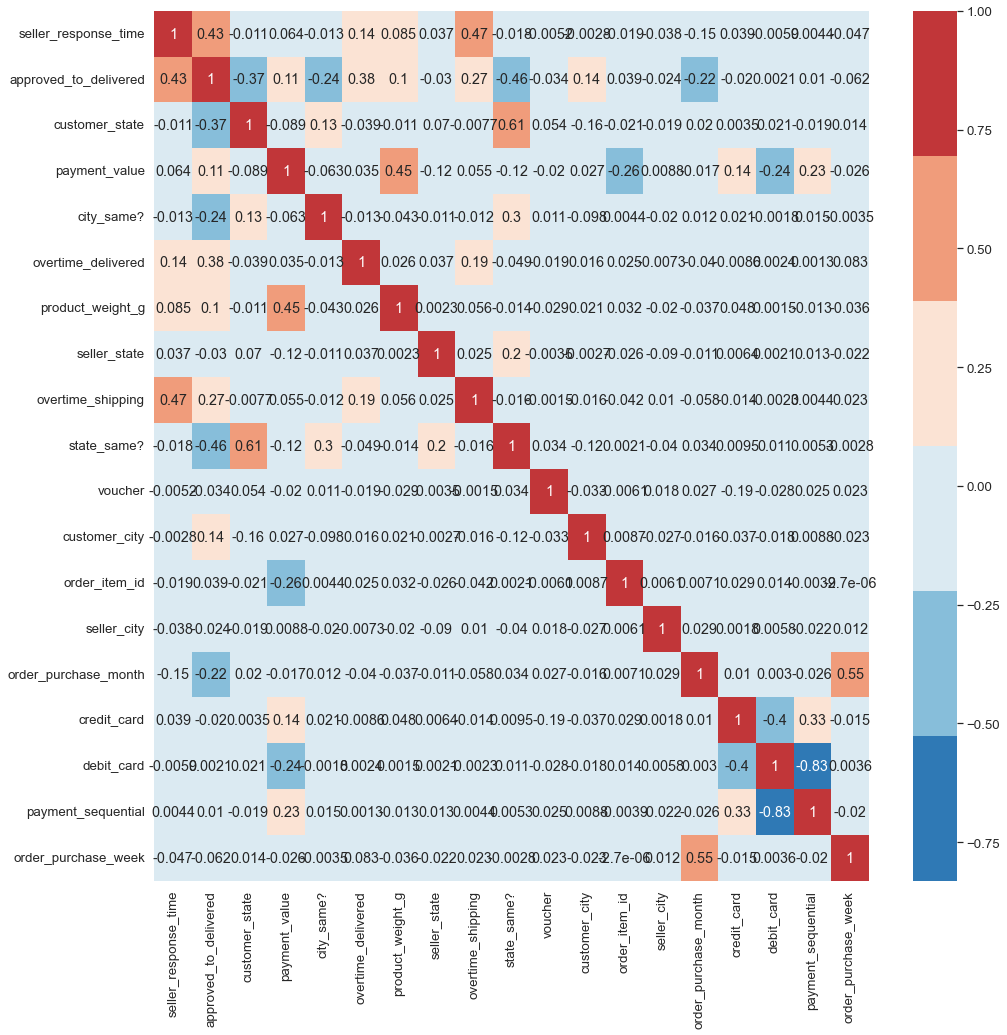

In [311]:
#Heatmap
corr = X_train_mi_manual.corr(method='spearman')
plt.figure(figsize=(16,16)); sns.set(font_scale = 1.2)
palette_heatmap = sns.color_palette("RdBu")
palette_heatmap.reverse()
sns.heatmap(corr, annot=True, cmap=palette_heatmap)

# **3. Modelling**

## **A. Model Selection**

Inspected models :
1. Logistic Regression
2. Decision Tree
3. Random Forrest
4. AdaBoost
5. XGBoost
6. SVM (poly and rbf)

In [318]:
#Fitting default logreg
logreg_def = LogisticRegression(random_state=143, max_iter=1000) #class_weight={0:0.5, 1:0.4})
logreg_def.fit(X_train_mi_manual, y_train)
#Fitting default DT
DT_def = DecisionTreeClassifier(random_state=143)
DT_def.fit(X_train_mi_manual, y_train)
#Fitting default RF
RF_def = RandomForestClassifier(random_state=143) #class_weight={0:0.4, 1:0.6})
RF_def.fit(X_train_mi_manual, y_train)
#Fitting default AdaBoost
AdaBoost_def = AdaBoostClassifier(random_state=143)
AdaBoost_def.fit(X_train_mi_manual, y_train)
#Fitting default XGBoost
XGBoost_def = XGBClassifier(random_state=143)
XGBoost_def.fit(X_train_mi_manual, y_train)
#Fitting default SVM-poly
SVM_poly_def = SVC(kernel='poly', random_state=143)
SVM_poly_def.fit(X_train_mi_manual, y_train)
#Fitting default SVM-rbf
SVM_rbf_def = SVC(kernel='rbf', random_state=143)
SVM_rbf_def.fit(X_train_mi_manual, y_train)

SVC(random_state=143)

In [145]:
#Color map on each evaluation metrics (0.7 being the success criteria)
def color(val):
    if val > 0.7:
        return 'background: darkgreen'
    if val > 0.6:
        return 'background: darkblue'

In [185]:
# Function to call classification report
def class_rep(estimator, x, y):
    y_pred = estimator.predict(x)
    print(classification_report(y, y_pred, labels=[1,0]))

In [146]:
# Classification report as DataFrame
def df_class_rep(estimator,est_name, x, y):
    y_pred = estimator.predict(x)
    
    #Transforming df
    a = pd.DataFrame(classification_report(y, y_pred, labels=[1,0], output_dict=True))
    acc = a['accuracy'].reset_index(drop=True).loc[[0,1]]
    acc.index = acc.index.map(str)
    a = a.loc[['precision','recall','f1-score'], ['1','0']].append(acc).T
    
    #Multi index estimator->label
    a['estimator'] = est_name
    a = a.reset_index(col_fill='Label').rename(columns={'index':'Label'})
    a = a.set_index(['estimator','Label'])
    
    return a

### **Fitting on Train Set**

In [319]:
logreg_train_df = df_class_rep(logreg_def, 'Logistic_Regression', X_train_mi_manual, y_train)
dt_train_df = df_class_rep(DT_def, 'Decision_Tree', X_train_mi_manual, y_train)
rf_train_df = df_class_rep(RF_def, 'Random_Forest', X_train_mi_manual, y_train)
ada_train_df = df_class_rep(AdaBoost_def, 'AdaBoost', X_train_mi_manual, y_train)
xgb_train_df = df_class_rep(XGBoost_def, 'XGBoost', X_train_mi_manual, y_train)
svm_poly_train_df = df_class_rep(SVM_poly_def, 'SVM-poly', X_train_mi_manual, y_train)
svm_rbf_train_df = df_class_rep(SVM_rbf_def, 'SVM-rbf', X_train_mi_manual, y_train)

In [320]:
#Classification report summary for train test
summary_train = pd.concat([logreg_train_df, 
                           dt_train_df, rf_train_df, 
                           ada_train_df, xgb_train_df, 
                           svm_poly_train_df, svm_rbf_train_df])
summary_train.sort_values('accuracy', ascending=False).style.applymap(color)

### **Fitting on Test Set**

In [321]:
logreg_test_df = df_class_rep(logreg_def, 'Logistic_Regression', X_test_mi_manual, y_test)
dt_test_df = df_class_rep(DT_def, 'Decision_Tree', X_test_mi_manual, y_test)
rf_test_df = df_class_rep(RF_def, 'Random_Forest', X_test_mi_manual, y_test)
ada_test_df = df_class_rep(AdaBoost_def, 'AdaBoost', X_test_mi_manual, y_test)
xgb_test_df = df_class_rep(XGBoost_def, 'XGBoost', X_test_mi_manual, y_test)
svm_poly_test_df = df_class_rep(SVM_poly_def, 'SVM-poly', X_test_mi_manual, y_test)
svm_rbf_test_df = df_class_rep(SVM_rbf_def, 'SVM-rbf', X_test_mi_manual, y_test)

In [326]:
#Classification report summary for test test
summary_test = pd.concat([logreg_test_df, 
                          dt_test_df, rf_test_df, 
                          ada_test_df, xgb_test_df, 
                          svm_poly_test_df, svm_rbf_test_df])
# Accuracy difference between train and test set
summary_test['accuracy_dif'] = summary_test['accuracy']-summary_train['accuracy']
summary_test.sort_values('accuracy', ascending=False).style.applymap(color)

### **Conclusion**
From the above screening result, I decided to use **Random Forest and AdaBoost as the primary model** candidate since they both have the best test-set performance. **I'm also interested in inspecting LogReg further** since it's the only model that loses the least amount of performance on test-set.

## **B. Model Tuning**

In summary the model developed **need to have less FP** to get better results in achieving Success Criteria, and this is the primary goal of the tuning process that I'll done.

However it's definitely true that on the process to reduce FP Rate, there's a big chance of tradeoff with increasing the number of FN, but I think putting the context of this project it's better to prefer low FP-high FN than low FN-high FP.

In [151]:
sns.set_theme(style="white", palette=None)

In [178]:
# Scorer to help reduce False Positive.
scorer = make_scorer(lambda y, y_pred, **kwargs: roc_auc_score(y, y_pred, average='macro'))

In [400]:
# Function to visualize confusion matrix
def conf_matrix(cf):    
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf.flatten()/np.sum(cf)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted');plt.ylabel('True')

### **1. Logistic Regression Tuning**

In [338]:
penalty = ['l1', 'l2']
C = np.logspace(-4,4,10)
solver =['newton-cg', 'saga', 'lbfgs']
hyperparameters = dict(penalty=penalty, C=C, solver=solver)

GSCV = GridSearchCV(LogisticRegression(random_state=143, max_iter=3000), 
                    param_grid = hyperparameters, scoring=scorer, cv = 5)

In [339]:
#Optimal penalty for train set WITH feature selection
GSCV.fit(X_train_mi_manual, y_train)
GSCV.best_params_

{'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'saga'}

In [340]:
logreg_opt = LogisticRegression(random_state=143, max_iter=3000, **GSCV.best_params_)
logreg_opt.fit(X_train_mi_manual, y_train)

LogisticRegression(C=2.782559402207126, max_iter=3000, penalty='l1',
                   random_state=143, solver='saga')

In [341]:
#Classification Report of optimized LogReg model on TEST SET (Default Threshold)
class_rep(logreg_opt, X_test_mi_manual, y_test)

              precision    recall  f1-score   support

           1       0.63      0.91      0.75      1180
           0       0.67      0.26      0.37       835

    accuracy                           0.64      2015
   macro avg       0.65      0.58      0.56      2015
weighted avg       0.65      0.64      0.59      2015



#### **Threshold Optimization**

In [343]:
y_prob_train_logreg = logreg_opt.predict_proba(X_train_mi_manual)[:,1]

<AxesSubplot:>

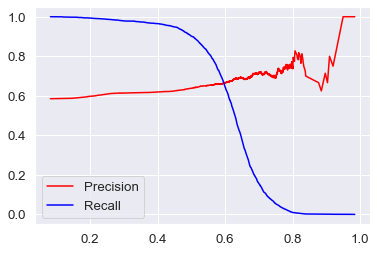

In [344]:
pre, rec, thre = precision_recall_curve(y_train, y_prob_train_logreg)
sns.lineplot(x = thre, y = pre[:-1], color = 'red', label='Precision')
sns.lineplot(x = thre, y = rec[:-1], color = 'blue', label='Recall')

In [372]:
pre_line = LineString(np.column_stack((pre[:-1], thre)))
rec_line = LineString(np.column_stack((rec[:-1], thre)))
point_thre = rec_line.intersection(pre_line)
opt_thre = point_thre.y*1.11
print(opt_thre)

0.6618023655875598


In [373]:
#Classification Report of optimized LogReg model on TRAIN SET (Optimal Threshold)
y_pred_train = (y_prob_train_logreg >= opt_thre)
print(classification_report(y_train, y_pred_train, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.68      0.31      0.43      2751
           0       0.45      0.80      0.58      1948

    accuracy                           0.51      4699
   macro avg       0.57      0.55      0.50      4699
weighted avg       0.59      0.51      0.49      4699



In [374]:
#Classification Report of optimized LogReg model on TEST SET (Optimal Threshold)
y_prob_test = logreg_opt.predict_proba(X_test_mi_manual)[:,1]
y_pred_test = (y_prob_test >= opt_thre)
print(classification_report(y_test, y_pred_test, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.71      0.38      0.49      1180
           0       0.47      0.78      0.59       835

    accuracy                           0.54      2015
   macro avg       0.59      0.58      0.54      2015
weighted avg       0.61      0.54      0.53      2015



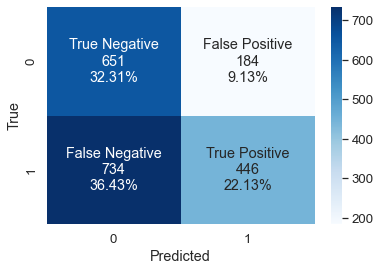

In [401]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix(cf_matrix)

### **2. Random Forest Tuning**

#### **Hyperparameter Tuning**

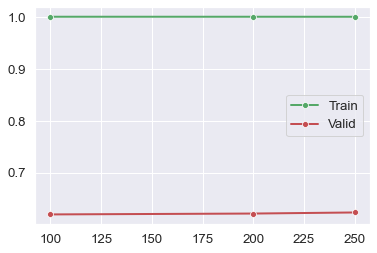

In [380]:
#Number of Estimators Tuning
n_estimators = [100, 200, 250]
train = []; valid = []; a = []

for x in n_estimators:
    result = cross_validate(RandomForestClassifier(random_state=143, n_estimators=x),
                            X_train_mi_manual, y_train, scoring=scorer, cv=5, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r'])
plt.show() #Opt. Value : Default

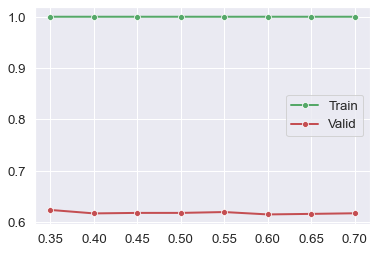

In [523]:
#Max Features Tuning
max_features = np.arange(0.35, 0.75, 0.05)
train = []; valid = []; a = []

for x in max_features:
    result = cross_validate(RandomForestClassifier(random_state=143, max_features=x),
                            X_train_mi_manual, y_train, scoring=scorer, cv=5, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r']) #Opt. Value : 0.7
plt.show()

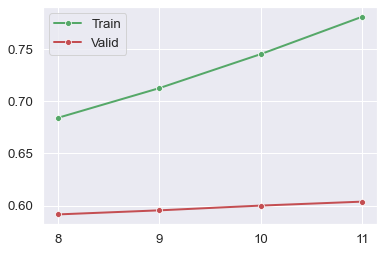

In [525]:
#Max Depth Tuning
max_depth = np.arange(8,12,1)
train = []; valid = []; a = []

for x in max_depth:
    result = cross_validate(RandomForestClassifier(random_state=143, max_features=0.7, max_depth=x),
                            X_train_mi_manual, y_train, cv=5, scoring=scorer, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r']); plt.xticks(max_depth)
plt.show() #Opt. Value : 11

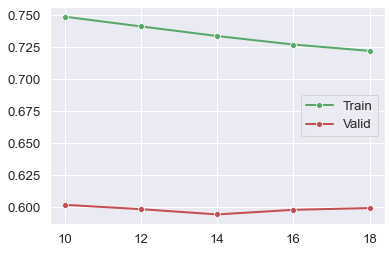

In [526]:
#Min Samples to Split Tuning
min_samples_split = np.arange(10,20,2)
train = []; valid = []; a = []

for x in min_samples_split:
    result = cross_validate(RandomForestClassifier(random_state=123, max_features=0.7, max_depth=11,
                                                   min_samples_split=x),
                            X_train_mi_manual, y_train, cv=5,scoring=scorer, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r'])
plt.show() #Opt. Value : 10

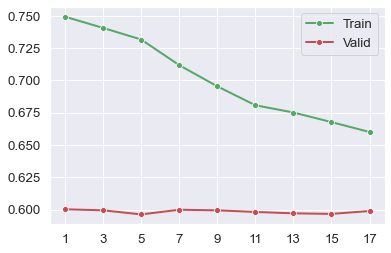

In [527]:
#Min Samples per Leaf Tuning
min_samples_leaf = np.arange(1,18,2)
train = []; valid = []; a = []

for x in min_samples_leaf:
    result = cross_validate(RandomForestClassifier(random_state=143, max_features=0.7, max_depth=11,
                                                    min_samples_split=10, min_samples_leaf=x),
                            X_train_mi_manual, y_train, cv=5, scoring=scorer, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r']); plt.xticks(min_samples_leaf)
plt.show() #Opt. value : 11

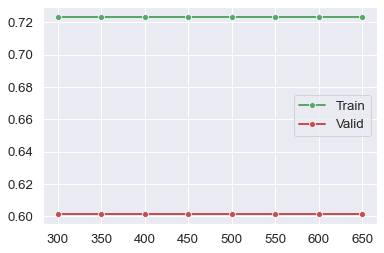

In [528]:
#Max Number of Leafes Tuning
max_leaf_nodes = np.arange(300,700,50)
train = []; valid = []; a = []

for x in max_leaf_nodes:
    result = cross_validate(RandomForestClassifier(random_state=123, max_features=0.7, max_depth=11,
                                                   min_samples_split=10, min_samples_leaf=11, max_leaf_nodes=x),
                            X_train_mi_manual, y_train, cv=5, scoring=scorer, return_train_score= True)
    
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='Train', marker='o', lw =2)
sns.lineplot(x = a, y=valid, label='Valid', marker='o', lw =2)
sns.set_palette(['g','r'])
plt.show() #Opt. value : Default

In [530]:
RF_opt = RandomForestClassifier(random_state=143, max_features=0.7, max_depth=11, min_samples_split=10, min_samples_leaf=11)
RF_opt.fit(X_train_mi_manual, y_train)

RandomForestClassifier(max_depth=11, max_features=0.7, min_samples_leaf=11,
                       min_samples_split=10, random_state=143)

In [531]:
#Classification Report of optimized RF model on TEST SET (Default Threshold)
class_rep(RF_opt, X_test_mi_manual, y_test)

              precision    recall  f1-score   support

           1       0.64      0.89      0.75      1180
           0       0.66      0.30      0.42       835

    accuracy                           0.65      2015
   macro avg       0.65      0.60      0.58      2015
weighted avg       0.65      0.65      0.61      2015



#### **Threshold Optimization**

In [532]:
y_prob_train_RF = RF_opt.predict_proba(X_train_mi_manual)[:,1]

<AxesSubplot:>

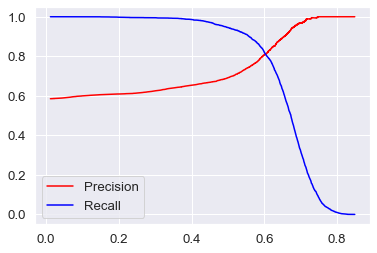

In [533]:
pre, rec, thre = precision_recall_curve(y_train, y_prob_train_RF)
sns.lineplot(x = thre, y = pre[:-1], color = 'red', label='Precision')
sns.lineplot(x = thre, y = rec[:-1], color = 'blue', label='Recall')

In [543]:
pre_line = LineString(np.column_stack((pre[:-1], thre)))
rec_line = LineString(np.column_stack((rec[:-1], thre)))
point_thre = rec_line.intersection(pre_line)
opt_thre_RF = point_thre.y*1.08
print(opt_thre_RF)

0.6510452714708254


In [544]:
#Classification Report of optimized LogReg model on TRAIN SET (Optimal Threshold)
y_pred_train = (y_prob_train_RF >= opt_thre_RF)
print(classification_report(y_train, y_pred_train, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.90      0.62      0.74      2751
           0       0.63      0.90      0.74      1948

    accuracy                           0.74      4699
   macro avg       0.76      0.76      0.74      4699
weighted avg       0.78      0.74      0.74      4699



In [545]:
#Classification Report of optimized LogReg model on TEST SET (Optimal Threshold)
y_prob_test = RF_opt.predict_proba(X_test_mi_manual)[:,1]
y_pred_test = (y_prob_test >= opt_thre_RF)
print(classification_report(y_test, y_pred_test, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.70      0.48      0.57      1180
           0       0.49      0.71      0.58       835

    accuracy                           0.58      2015
   macro avg       0.60      0.60      0.58      2015
weighted avg       0.61      0.58      0.58      2015



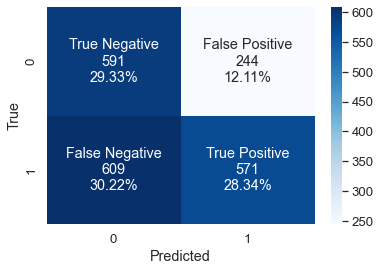

In [546]:
cf_matrix_RF = confusion_matrix(y_test, y_pred_test)
conf_matrix(cf_matrix_RF)

### **3. AdaBoost Tuning**

#### **Hyperparameter Tuning**

In [457]:
# NOTE : This codeblock runtime is pretty long (~5-8 min), so uncomment if you want to redo the process

# grid = dict()
# grid['base_estimator']=[DecisionTreeClassifier(), LogisticRegression()]
# grid['n_estimators'] = [50, 100, 500]
# grid['learning_rate'] = [0.1, 0.3, 0.5, 1.0]
# gscv_ada = GridSearchCV(AdaBoostClassifier(), param_grid=grid, scoring=scorer, cv=5)
# gscv_ada.fit(X_train_mi_manual, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(),
                                            LogisticRegression()],
                         'learning_rate': [0.1, 0.3, 0.5, 1.0],
                         'n_estimators': [50, 100, 500]},
             scoring=make_scorer(<lambda>))

In [458]:
gscv_ada.best_params_

{'base_estimator': DecisionTreeClassifier(),
 'learning_rate': 0.3,
 'n_estimators': 50}

In [502]:
AdaBoost_opt = AdaBoostClassifier(random_state=143, n_estimators=50, learning_rate=0.8)
AdaBoost_opt.fit(X_train_mi_manual, y_train)

AdaBoostClassifier(learning_rate=0.8, random_state=143)

In [503]:
#Classification Report of optimized AdaBoost model on TEST SET (Default Threshold)
class_rep(AdaBoost_opt, X_test_mi_manual, y_test)

              precision    recall  f1-score   support

           1       0.64      0.89      0.75      1180
           0       0.66      0.29      0.40       835

    accuracy                           0.64      2015
   macro avg       0.65      0.59      0.57      2015
weighted avg       0.65      0.64      0.60      2015



#### **Threshold Optimization**

In [504]:
y_prob_train_Ada = AdaBoost_opt.predict_proba(X_train_mi_manual)[:,1]

<AxesSubplot:>

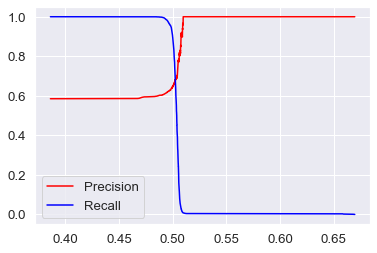

In [505]:
pre, rec, thre = precision_recall_curve(y_train, y_prob_train_Ada)
sns.lineplot(x = thre, y = pre[:-1], color = 'red', label='Precision')
sns.lineplot(x = thre, y = rec[:-1], color = 'blue', label='Recall')

In [518]:
pre_line = LineString(np.column_stack((pre[:-1], thre)))
rec_line = LineString(np.column_stack((rec[:-1], thre)))
point_thre = rec_line.intersection(pre_line)
opt_thre_Ada = point_thre.y*1.003
print(opt_thre_Ada)

0.5039776305203748


In [519]:
#Classification Report of optimized LogReg model on TRAIN SET (Optimal Threshold)
y_pred_train = (y_prob_train_Ada >= opt_thre_Ada)
print(classification_report(y_train, y_pred_train, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.70      0.45      0.55      2751
           0       0.48      0.72      0.58      1948

    accuracy                           0.57      4699
   macro avg       0.59      0.59      0.56      4699
weighted avg       0.61      0.57      0.56      4699



In [520]:
#Classification Report of optimized LogReg model on TEST SET (Optimal Threshold)
y_prob_test = AdaBoost_opt.predict_proba(X_test_mi_manual)[:,1]
y_pred_test = (y_prob_test >= opt_thre_Ada)
print(classification_report(y_test, y_pred_test, labels = [1,0]))

              precision    recall  f1-score   support

           1       0.70      0.49      0.57      1180
           0       0.49      0.70      0.58       835

    accuracy                           0.58      2015
   macro avg       0.59      0.59      0.58      2015
weighted avg       0.61      0.58      0.57      2015



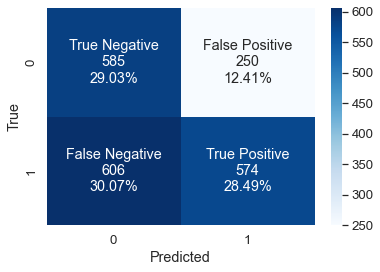

In [521]:
cf_matrix_Ada = confusion_matrix(y_test, y_pred_test)
conf_matrix(cf_matrix_Ada)

## **C. Final Model**

In [547]:
# Modified classification report as DataFrame Function (with custom threshold)
def df_class_rep_thre(estimator, est_name, x, y, threshold):
    y_prob = estimator.predict_proba(x)[:,1]
    y_pred = (y_prob >= threshold)
    
    #Transforming df
    a = pd.DataFrame(classification_report(y, y_pred, labels=[1,0], output_dict=True))
    acc = a['accuracy'].reset_index(drop=True).loc[[0,1]]
    acc.index = acc.index.map(str)
    a = a.loc[['precision','recall','f1-score'], ['1','0']].append(acc).T
    
    #Multi index estimator->label
    a['estimator'] = est_name
    a = a.reset_index(col_fill='Label').rename(columns={'index':'Label'})
    a = a.set_index(['estimator','Label'])
    
    return a

In [549]:
# Optimized threshold for the three models tuned
opt_thre, opt_thre_RF, opt_thre_Ada

(0.6618023655875598, 0.6510452714708254, 0.5039776305203748)

In [553]:
logreg_train_df_opt = df_class_rep_thre(logreg_opt, 'Logistic_Regression_opt', X_train_mi_manual, y_train, opt_thre)
rf_train_df_opt = df_class_rep_thre(RF_opt, 'Random_Forest_opt', X_train_mi_manual, y_train, opt_thre_RF)
ada_train_df_opt = df_class_rep_thre(AdaBoost_opt, 'AdaBoost_opt', X_train_mi_manual, y_train, opt_thre_Ada)

In [554]:
#Classification report summary for train test
summary_train_opt = pd.concat([logreg_train_df_opt, rf_train_df_opt, ada_train_df_opt])
summary_train_opt.sort_values('accuracy', ascending=False).style.applymap(color)

In [555]:
logreg_test_df_opt = df_class_rep_thre(logreg_opt, 'Logistic_Regression_opt', X_test_mi_manual, y_test, opt_thre)
rf_test_df_opt = df_class_rep_thre(RF_opt, 'Random_Forest_opt', X_test_mi_manual, y_test, opt_thre_RF)
ada_test_df_opt = df_class_rep_thre(AdaBoost_opt, 'AdaBoost_opt', X_test_mi_manual, y_test, opt_thre_Ada)

In [556]:
#Classification report summary for test test
summary_test_opt = pd.concat([logreg_test_df_opt, rf_test_df_opt, ada_test_df_opt])

summary_test_opt['accuracy_dif'] = summary_test_opt['accuracy']-summary_train_opt['accuracy']
summary_test_opt.sort_values('accuracy', ascending=False).style.applymap(color)

**Therefore from classification report above, Tuned RF model is chosen as the FINAL MODEL**

In [571]:
RF_opt.feature_importances_

array([1.47005359e-01, 2.83621772e-01, 3.79989187e-02, 1.38231521e-01,
       9.76710813e-04, 9.11517090e-02, 1.05790334e-01, 2.02927806e-02,
       9.41975433e-03, 1.11600004e-02, 2.02520372e-04, 4.99388305e-02,
       4.28877279e-02, 4.71525182e-02, 1.17649401e-02, 2.40460287e-03])

# **4. Back Testing**

In [588]:
backtest = pd.read_csv('model_backtesting_set.csv', sep=';')
backtest = backtest.drop(['customer_id', 'customer_unique_id', 'order_id', 'product_id', 'seller_id', 'order_status'], axis=1)
backtest.head(3)

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,19906,ourinhos,SP,19906,-22.990940,-49.887524,ourinhos,SP,2018-05-17 14:40:34,2018-05-18 00:14:56,2018-05-18 11:20:00,2018-05-30 20:44:25,2018-06-05 00:00:00,1,2018-05-24 00:14:56,166.0,15.25,1,credit_card,6,181.25,beleza_saude,20.0,1688.0,1.0,1450,30,12,16,3702,sao paulo,SP,health_beauty
1,11250,bertioga,SP,11250,-23.763952,-45.903124,bertioga,SP,2017-07-25 20:13:09,2017-07-25 20:25:16,2017-07-26 21:57:40,2017-07-31 18:29:56,2017-08-16 00:00:00,1,2017-07-31 20:25:16,15.0,15.10,1,credit_card,1,30.10,beleza_saude,17.0,341.0,1.0,255,17,13,15,81350,curitiba,PR,health_beauty
2,30130,belo horizonte,MG,30130,-19.931521,-43.933723,belo horizonte,MG,2017-03-17 08:20:43,2017-03-17 08:20:43,2017-03-22 09:37:35,2017-03-29 14:59:52,2017-04-17 00:00:00,1,2017-03-30 08:20:43,189.9,16.09,1,credit_card,3,205.99,papelaria,52.0,280.0,2.0,1800,18,45,32,3470,sao paulo,SP,stationery


In [589]:
backtest.shape

(2921, 33)

## **Missing Value Handling**

### **Simple Imputation**

In [592]:
#Scanning Imputation Method
Simple_imputer = []
mv_count = backtest.isna().sum()
for index, value in mv_count.iteritems():
    if value > 1:
        Simple_imputer.append(index)

print('Feature imputed using Simple Imputer : {}'.format(Simple_imputer))

Feature imputed using Simple Imputer : ['product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_category_name_english']


In [594]:
#Imputing designated columns with Simple Imputation (with SimpleImputer)
SI_median = SimpleImputer(strategy="median")
SI_mode = SimpleImputer(strategy="most_frequent")
for feature in Simple_imputer:
    if backtest[feature].dtype.kind in 'biufc':
        backtest[feature] = SI_median.fit_transform(backtest[feature].values.reshape(-1,1))
    else:
        backtest[feature] = SI_mode.fit_transform(backtest[feature].values.reshape(-1,1))

### **Datetime Imputation**

In [626]:
#Converting values to datetime type
backtest_datetime = backtest[datetime_col]
backtest_datetime = pd.to_datetime(backtest_datetime.stack(), errors='coerce').unstack()
backtest_datetime.head(3)

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date
0,2018-05-17 14:40:34,2018-05-18 00:14:56,2018-05-18 11:20:00,2018-05-30 20:44:25,2018-06-05,2018-05-24 00:14:56
1,2017-07-25 20:13:09,2017-07-25 20:25:16,2017-07-26 21:57:40,2017-07-31 18:29:56,2017-08-16,2017-07-31 20:25:16
2,2017-03-17 08:20:43,2017-03-17 08:20:43,2017-03-22 09:37:35,2017-03-29 14:59:52,2017-04-17,2017-03-30 08:20:43


In [633]:
#Filling missing purchase timestamp with order approved at
for idx in backtest_datetime.index:
    if np.isnat(np.datetime64(str(backtest_datetime.loc[idx, 'order_approved_at']))):
        fill = str(backtest_datetime.loc[idx, 'order_purchase_timestamp'])
        backtest_datetime.loc[idx, 'order_approved_at'] = fill

In [636]:
backtest_datetime.isna().sum()

order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
shipping_limit_date              0
dtype: int64

## **Datetime Processing**

In [637]:
backtest_datetime_eng = pd.DataFrame()
#A. Datetime Unpacking
backtest_datetime_eng['order_purchase_year'] = backtest_datetime['order_purchase_timestamp'].dt.year
backtest_datetime_eng['order_purchase_month'] = backtest_datetime['order_purchase_timestamp'].dt.month
backtest_datetime_eng['order_purchase_week'] = backtest_datetime['order_purchase_timestamp'].dt.isocalendar().week
backtest_datetime_eng['order_purchase_dayofweek'] = backtest_datetime['order_purchase_timestamp'].dt.dayofweek

#B. Overtime
backtest_datetime_eng['overtime_shipping'] = (backtest_datetime['order_delivered_carrier_date'] > backtest_datetime['shipping_limit_date']).astype('int')
backtest_datetime_eng['overtime_delivered'] = (backtest_datetime['order_delivered_customer_date'] > backtest_datetime['order_estimated_delivery_date']).astype('int')

#Timedelta features
#Interval between order being approved and delivered by seller
backtest_datetime_eng['seller_response_time'] = (backtest_datetime['order_delivered_carrier_date'] - backtest_datetime['order_approved_at']).apply(delta_to_hour)
#Interval between order being approved and delivered to customer
backtest_datetime_eng['approved_to_delivered'] = (backtest_datetime['order_delivered_customer_date'] - backtest_datetime['order_approved_at']).apply(delta_to_hour)
backtest_datetime_eng.head()

,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,2018,5,20,3,0,0,11.084444,308.491389
1,2017,7,30,1,0,0,25.540000,142.077778
2,2017,3,11,4,0,0,121.281111,294.652500
3,2017,12,52,2,0,0,25.894722,168.002778
4,2018,7,27,3,0,0,8.966111,161.691944


In [638]:
backtest_cleaned = backtest.drop(datetime_col, axis=1)
backtest_cleaned = pd.concat([backtest_cleaned, backtest_datetime_eng], axis=1)
backtest_cleaned.head()

,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_purchase_year,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,seller_response_time,approved_to_delivered
0,19906,ourinhos,SP,19906,-22.990940,-49.887524,ourinhos,SP,1,166.0,15.25,1,credit_card,6,181.25,beleza_saude,20.0,1688.0,1.0,1450,30,12,16,3702,sao paulo,SP,health_beauty,2018,5,20,3,0,0,11.084444,308.491389
1,11250,bertioga,SP,11250,-23.763952,-45.903124,bertioga,SP,1,15.0,15.10,1,credit_card,1,30.10,beleza_saude,17.0,341.0,1.0,255,17,13,15,81350,curitiba,PR,health_beauty,2017,7,30,1,0,0,25.540000,142.077778
2,30130,belo horizonte,MG,30130,-19.931521,-43.933723,belo horizonte,MG,1,189.9,16.09,1,credit_card,3,205.99,papelaria,52.0,280.0,2.0,1800,18,45,32,3470,sao paulo,SP,stationery,2017,3,11,4,0,0,121.281111,294.652500
3,13604,araras,SP,13604,-22.330936,-47.379980,araras,SP,2,19.9,12.48,1,credit_card,1,64.76,eletronicos,52.0,390.0,1.0,150,20,13,18,87050,maringa,PR,electronics,2017,12,52,2,0,0,25.894722,168.002778
4,22631,rio de janeiro,RJ,22631,-23.004489,-43.368646,rio de janeiro,RJ,1,19.9,15.24,1,boleto,1,35.14,malas_acessorios,44.0,503.0,8.0,250,20,26,15,3573,sao paulo,SP,luggage_accessories,2018,7,27,3,0,0,8.966111,161.691944


In [640]:
backtest_cleaned.shape

(2921, 35)

## **Feature Engineering**

### **Numerical FE**

In [641]:
backtest_num = backtest_cleaned.loc[:,num_cols]
backtest_num.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
0,-22.990940,-49.887524,166.0,15.25,181.25,20.0,1688.0,1450,30,12,16,11.084444,308.491389
1,-23.763952,-45.903124,15.0,15.10,30.10,17.0,341.0,255,17,13,15,25.540000,142.077778
2,-19.931521,-43.933723,189.9,16.09,205.99,52.0,280.0,1800,18,45,32,121.281111,294.652500


In [642]:
#Winsorizing geologication cols
for col in geo_num:
    backtest_num[col] = winsorize(backtest_num[col], (0.01,0.05))

In [644]:
#Checking the efectiveness of transformation in reducing outliers
backtest_num_transformed = backtest_num.copy()
a=1
#Transforming data
for col in backtest_num.columns:
    if col == 'product_name_lenght':
        backtest_num_transformed[col] = backtest_num[col].apply(square_transform)
    else:
        backtest_num_transformed[col] = backtest_num[col].apply(log_transform_custom)
#Scaling all data
backtest_num_transformed = pd.DataFrame(scaler.transform(backtest_num_transformed), 
                                       columns = scaler.feature_names_in_,
                                       index = list(backtest_num_transformed.index) )
for col in backtest_num.columns:
    print('\033[1m'+str(a)+'.', end=' ')
    print('\033[1m'+col.replace("_"," ").upper())
    
    print('Numbers of outlier before transformation : {}'.format(std_outliers(backtest_num[col])))
    print('Numbers of outlier after transformation : {}'.format(std_outliers(backtest_num_transformed[col])))
    print('-'*100); a += 1

1. GEOLOCATION LAT
Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
2. GEOLOCATION LNG
Numbers of outlier before transformation : 0
Numbers of outlier after transformation : 0
----------------------------------------------------------------------------------------------------
3. PRICE
Numbers of outlier before transformation : 47
Numbers of outlier after transformation : 18
----------------------------------------------------------------------------------------------------
4. FREIGHT VALUE
Numbers of outlier before transformation : 52
Numbers of outlier after transformation : 60
----------------------------------------------------------------------------------------------------
5. PAYMENT VALUE
Numbers of outlier before transformation : 45
Numbers of outlier after transformation : 35
----------------------------------------------------------------

In [645]:
backtest_num_transformed.head(3)

,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered
0,-0.023549,-0.730213,0.718731,-0.139156,0.461345,-1.482155,1.040389,0.406655,0.244591,-0.087464,-0.319488,-0.963218,0.340420
1,-0.254512,0.125933,-1.248900,-0.163357,-1.134411,-1.556902,-0.544511,-0.563073,-0.511352,0.000000,-0.411150,-0.389874,-0.561843
2,0.969991,0.576360,0.830943,-0.007624,0.576223,0.069360,-0.739468,0.527443,-0.436167,1.403974,0.683378,0.723438,0.286924


### **Categorical FE**

In [646]:
backtest_cat = backtest_cleaned.loc[:,cat_cols]
backtest_cat.head(3)

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_type,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered
0,ourinhos,SP,ourinhos,1,1,credit_card,6,1.0,sao paulo,SP,health_beauty,5,20,3,0,0
1,bertioga,SP,bertioga,1,1,credit_card,1,1.0,curitiba,PR,health_beauty,7,30,1,0,0
2,belo horizonte,MG,belo horizonte,1,1,credit_card,3,2.0,sao paulo,SP,stationery,3,11,4,0,0


In [647]:
backtest_cat.shape

(2921, 16)

In [648]:
#Adding Features
backtest_cat['state_same?'] = (backtest_cat['customer_state'] == backtest_cat['seller_state']).astype('int')
backtest_cat['city_same?']  = (backtest_cat['customer_city'] == backtest_cat['seller_city']).astype('int')

In [649]:
#Aggregating values #1
agg_cols = ['order_item_id', 'payment_sequential', 'payment_installments', 'product_photos_qty']
agg_threshold = [6,6,9,8]
for i, col in enumerate(agg_cols):
    backtest_cat[col] = backtest_cat[col].apply(lambda x: agg_threshold[i] if x>= agg_threshold[i] else x)

In [650]:
#Aggregating values #2
agg_cols_other = ['customer_city', 'customer_state', 'geolocation_city', 'seller_city', 'seller_state', 'product_category_name_english']
for col in agg_cols_other:
    categories_list = list(X_train_cat[col].unique())
    categories_list.remove('Other')
    
    backtest_cat[col] = backtest_cat[col].apply(lambda x: x if x in categories_list else 'Other')

In [651]:
backtest_cat_enc = backtest_cat.copy()

In [652]:
#One Hot Encoding
OHE = OneHotEncoder(handle_unknown='ignore')
payment_OHE = OHE.fit_transform(backtest_cat_enc['payment_type'].to_numpy().reshape(-1,1)).toarray()
df_payment_OHE = pd.DataFrame(payment_OHE, 
                              columns=list(backtest_cat_enc['payment_type'].unique()), 
                              index=list(backtest_cat_enc.index))

backtest_cat_enc = backtest_cat_enc.drop('payment_type', axis=1)
backtest_cat_enc = pd.concat([backtest_cat_enc, df_payment_OHE], axis=1)

In [653]:
#Frequency Encoding
for col in freq_enc_cols:
    freq_dict = {}
    freq_df = pd.DataFrame(X_train_cat.value_counts(col)/len(X_train_cat), columns=['frequency']).reset_index()
    #Assigning frequency to each categorical values
    for value in freq_df[col].unique():
        freq_dict[value] = freq_df[freq_df[col]==value]['frequency'].item()
    
    backtest_cat_enc[col] = backtest_cat_enc[col].apply(lambda x: freq_dict[x])

In [654]:
backtest_cat_enc1 = backtest_cat_enc.reindex(columns=list(X_train_cat_enc.columns))

In [655]:
backtest_cat_enc1.head()

,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
0,0.470526,0.373058,0.503937,0.870185,0.956587,0.037880,0.514578,0.249628,0.703341,0.087465,0.096403,0.025750,0.143860,0,0,1,0,1.0,0.0,0.0,0.0
1,0.470526,0.373058,0.503937,0.870185,0.956587,0.497978,0.514578,0.028942,0.084486,0.087465,0.106618,0.025537,0.159396,0,0,0,0,1.0,0.0,0.0,0.0
2,0.047883,0.190253,0.047883,0.870185,0.956587,0.099383,0.206214,0.249628,0.703341,0.023409,0.096403,0.020430,0.145989,0,0,0,0,1.0,0.0,0.0,0.0
3,0.470526,0.373058,0.503937,0.090870,0.956587,0.497978,0.514578,0.025112,0.084486,0.026176,0.058523,0.006597,0.148329,0,0,0,0,1.0,0.0,0.0,0.0
4,0.122792,0.193658,0.122792,0.870185,0.956587,0.497978,0.012981,0.249628,0.703341,0.011066,0.106618,0.019791,0.143860,0,0,0,0,0.0,1.0,0.0,0.0


### **Joining Data**

In [656]:
backtest_transformed = pd.concat([backtest_num_transformed, backtest_cat_enc1], axis=1)
print(backtest_transformed.shape)
backtest_transformed.head(3)

(2921, 34)


,geolocation_lat,geolocation_lng,price,freight_value,payment_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_response_time,approved_to_delivered,customer_city,customer_state,geolocation_city,order_item_id,payment_sequential,payment_installments,product_photos_qty,seller_city,seller_state,product_category_name_english,order_purchase_month,order_purchase_week,order_purchase_dayofweek,overtime_shipping,overtime_delivered,state_same?,city_same?,boleto,credit_card,voucher,debit_card
0,-0.023549,-0.730213,0.718731,-0.139156,0.461345,-1.482155,1.040389,0.406655,0.244591,-0.087464,-0.319488,-0.963218,0.340420,0.470526,0.373058,0.503937,0.870185,0.956587,0.037880,0.514578,0.249628,0.703341,0.087465,0.096403,0.025750,0.143860,0,0,1,0,1.0,0.0,0.0,0.0
1,-0.254512,0.125933,-1.248900,-0.163357,-1.134411,-1.556902,-0.544511,-0.563073,-0.511352,0.000000,-0.411150,-0.389874,-0.561843,0.470526,0.373058,0.503937,0.870185,0.956587,0.497978,0.514578,0.028942,0.084486,0.087465,0.106618,0.025537,0.159396,0,0,0,0,1.0,0.0,0.0,0.0
2,0.969991,0.576360,0.830943,-0.007624,0.576223,0.069360,-0.739468,0.527443,-0.436167,1.403974,0.683378,0.723438,0.286924,0.047883,0.190253,0.047883,0.870185,0.956587,0.099383,0.206214,0.249628,0.703341,0.023409,0.096403,0.020430,0.145989,0,0,0,0,1.0,0.0,0.0,0.0


In [657]:
X_train_transformed.shape

(4699, 34)

### **Feature Selection**

In [658]:
#Feature selection
backtest_mi_manual = backtest_transformed[X_train_mi_manual.columns]
backtest_mi_manual.shape

(2921, 16)

In [659]:
X_train_mi_manual.shape

(4699, 16)

# **Label Prediction**

In [670]:
# Predicting label using optimized Random Forest model
backtest_prob = RF_opt.predict_proba(backtest_mi_manual)[:,1]
backtest_pred = (backtest_prob >= opt_thre_RF).astype('int')

In [673]:
backtest_prediction = pd.DataFrame(backtest_pred, columns = ['label'], index = backtest_mi_manual.index)
backtest_prediction

,label
0,0
1,1
2,0
3,0
4,1
...,...
2916,0
2917,0
2918,0
2919,1


In [675]:
backtest_prediction['label'].value_counts()/len(backtest_prediction)

0    0.605957
1    0.394043
Name: label, dtype: float64

In [676]:
# Exporting prediction data
#backtest_prediction.to_csv('backtest prediction.csv', index=False)